## Notes
- [x] percentage missing
- [x] skewness
- [ ] condon features
- [ ] high sample weights for false negatives
- [ ] imputation for the missing nucleotide
- [ ] distance matrix like to measure how close two sequence are

## Next Week
- [ ] information about the data

# Explore data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
%matplotlib inline
pd.options.display.precision = 3

In [2]:
# load responses-pseudo.csv - the result of antibiotic resistence of pseudomonas
# 122 * 2 (2 antibiotics)
resp = pd.read_csv('../data/responses-pseudo.csv', names=['id', 'lab-id', 'carb', 'toby'], skiprows=1)
resp.drop('lab-id', axis=1, inplace=True)

In [3]:
# load concatenated.fasta - the gene sequence of pseudomonas
# 122 * (483333 -> 261868)
src = SeqIO.parse('../data/concatenated.fasta', 'fasta')
data = [(record.id, record.seq._data) for record in src]
seq = pd.DataFrame(data=data, columns=['id', 'sequence'])

In [4]:
# merge DataFrames of two files into one DataFrame
records = pd.merge(seq, resp, on='id')

In [5]:
# calculate missing number and percentage of nucleotides of each sequence
from collections import Counter

seq_len = np.mean(records['sequence'].apply(len))
records['missing'] = records['sequence'].apply(lambda seq: Counter(seq)['-'])

In [6]:
records['missing_percentage'] = records['missing'] / seq_len * 100
records

,id,sequence,carb,toby,missing,missing_percentage
0,TA151,ATGAGTGATCTGCCAAGTCCGAAGAAACACAAGACCTCGAACTGGT...,True,False,31842,6.588
1,IC1,ATGAGTGATCTGCCAAGTCCGAAGAAACACAAGACCTCGAACTGGT...,False,False,46071,9.532
2,A237,ATGAGTGATCTGCCAAGTCCGAAGAAACACAAGACCTCGAACTGGT...,True,False,44514,9.210
3,5920,ATGAGTGATCTGCCAAGTCCGAAGAAACACAAGACCTCGAACTGGT...,NaN,NaN,49497,10.241
4,LiA96,ATGAGTGATCTGCCAAGTCCGAAGAAACACAAGACCTCGAACTGGT...,False,False,44067,9.117
...,...,...,...,...,...,...
117,JD318,----------------------------------------------...,False,False,77766,16.090
118,Jp238,----------------------------------------------...,False,False,43062,8.909
119,Jp1303,----------------------------------------------...,False,False,44151,9.135
120,JD304,----------------------------------------------...,False,False,75465,15.613


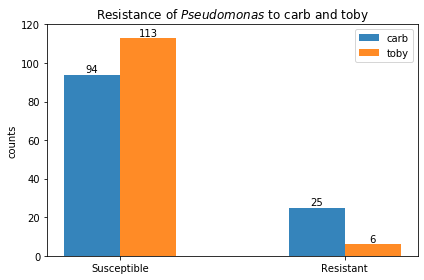

In [7]:
# show the skewness of the data set
def show_count(rects):
    '''Show the height of each bar in the bar chart'''
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                     xy=(rect.get_x() + rect.get_width()/2, height),
                     ha='center', va='bottom')

x = np.array([0, 1]) # False, True

counts_carb = records['carb'].value_counts()
carb = plt.bar(x=x-0.125, height=counts_carb, width=0.25, alpha=0.9, label='carb')
counts_toby = records['toby'].value_counts()
toby = plt.bar(x=x+0.125, height=counts_toby, width=0.25, alpha=0.9, label='toby')

show_count(carb)
show_count(toby)

plt.xticks(x, ['Susceptible', 'Resistant'])
plt.ylim((0, 120))
plt.ylabel('counts')
plt.title('Resistance of $Pseudomonas$ to carb and toby')

plt.tight_layout()
plt.legend()
plt.savefig('pseudo_skewness.png')
plt.show()

In [8]:
# calculate true/false percentage of two classes
counts = pd.DataFrame({'carb':counts_carb, 'toby':counts_toby})
counts.div(counts.sum() / 100)

,carb,toby
False,78.992,94.958
True,21.008,5.042


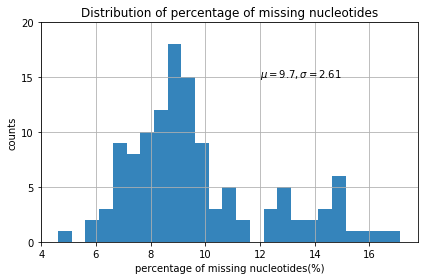

In [9]:
# show the missingness of the sequence
data = records['missing_percentage']
n, bins, patches = plt.hist(data, bins=25, alpha=0.9)
mu, sigma = np.mean(data), np.std(data)

plt.grid()
plt.yticks(ticks=range(0, 21, 5))
plt.ylabel('counts')
plt.xlabel('percentage of missing nucleotides(%)')
plt.title('Distribution of percentage of missing nucleotides')
plt.text(12, 15, '$\mu={:.3}, \sigma={:.3}$'.format(mu, sigma))

plt.tight_layout()
plt.savefig('pseudo_missingness_1.png')
plt.show()

In [10]:
highest_missing_percentage = np.max(records['missing_percentage'])
highest_missing_percentage

17.133529057606246

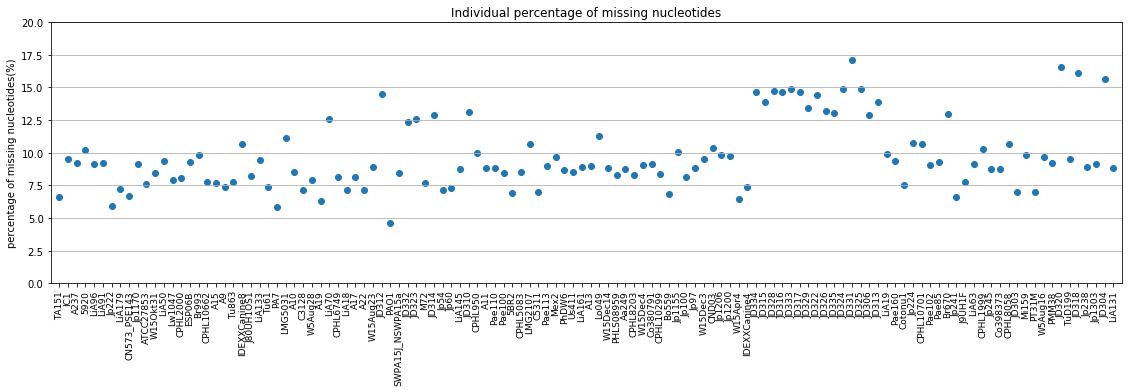

In [11]:
# show the individual missingness of the sequence
plt.figure(figsize=(19.2, 4.8))
plt.scatter(range(122), records['missing_percentage'])

plt.xlim((-1, 122))
plt.ylim((0, 20))
plt.xticks(ticks=range(122), labels=records['id'].to_list(), rotation=90, fontsize=9)
plt.ylabel('percentage of missing nucleotides(%)')
plt.title('Individual percentage of missing nucleotides')
plt.grid(axis='y')
plt.savefig('pseudo_missingness_2.png')
plt.show()

In [25]:
# group genes in the sequence by three (into condons)
# and count different number of condons across all samples
condonify = lambda seq: [seq[i:i+3] for i in range(0, len(seq), 3)]
sequence_condonified = records['sequence'].apply(condonify)
c = Counter()
for condons in sequence_condonified:
    c.update(Counter(condons))

In [28]:
len(c.keys())

125

In [32]:
# verify the result
sum(c.values()) * 3 / 122 == seq_len

True

# Experiment

## Encoding

In [121]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')

In [53]:
sequence = []
for seq in records['sequence']:
    sequence.append([nucleotide for nucleotide in seq])

In [54]:
sequence = np.array(sequence)
sequence.shape

(122, 483333)

In [57]:
encode_seq = encoder.fit_transform(sequence)

In [58]:
encode_seq

<122x815074 sparse matrix of type '<class 'numpy.float64'>'
	with 58966626 stored elements in Compressed Sparse Row format>

In [65]:
for i in encode_seq[0]:
    print(i)

  (0, 1)	1.0
  (0, 3)	1.0
  (0, 5)	1.0
  (0, 7)	1.0
  (0, 10)	1.0
  (0, 12)	1.0
  (0, 14)	1.0
  (0, 16)	1.0
  (0, 18)	1.0
  (0, 20)	1.0
  (0, 23)	1.0
  (0, 25)	1.0
  (0, 27)	1.0
  (0, 29)	1.0
  (0, 31)	1.0
  (0, 33)	1.0
  (0, 35)	1.0
  (0, 38)	1.0
  (0, 40)	1.0
  (0, 42)	1.0
  (0, 44)	1.0
  (0, 46)	1.0
  (0, 48)	1.0
  (0, 50)	1.0
  (0, 52)	1.0
  :	:
  (0, 815021)	1.0
  (0, 815023)	1.0
  (0, 815025)	1.0
  (0, 815027)	1.0
  (0, 815029)	1.0
  (0, 815031)	1.0
  (0, 815033)	1.0
  (0, 815035)	1.0
  (0, 815037)	1.0
  (0, 815039)	1.0
  (0, 815042)	1.0
  (0, 815044)	1.0
  (0, 815046)	1.0
  (0, 815048)	1.0
  (0, 815050)	1.0
  (0, 815052)	1.0
  (0, 815054)	1.0
  (0, 815056)	1.0
  (0, 815058)	1.0
  (0, 815061)	1.0
  (0, 815063)	1.0
  (0, 815066)	1.0
  (0, 815068)	1.0
  (0, 815070)	1.0
  (0, 815072)	1.0


In [69]:
len(encoder.get_feature_names())

815074

## Remove redundant feature

In [5]:
sequence = records['sequence']

In [6]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()

In [7]:
temp = pd.Series(['ACTG', 'CGTA'])
temp

0    ACTG
1    CGTA
dtype: object

In [8]:
forward = str.maketrans('-ACTG', '01234')
backward = str.maketrans('01234', '-ACTG')
def transformation(str):
    return [int(i) for i in str.translate(forward)]

In [9]:
print(selector.fit_transform(temp.apply(transformation).to_list()))
selector.get_support()

[[1 2 4]
 [2 4 1]]


array([ True,  True, False,  True])

In [10]:
%time tran = selector.fit_transform(sequence.apply(transformation).to_list())

CPU times: user 22.7 s, sys: 346 ms, total: 23 s
Wall time: 22.1 s


In [11]:
len(tran[0])

261868

In [12]:
tran_support = selector.get_support()

In [13]:
from collections import Counter
Counter(tran_support)
for i, v in enumerate(tran_support):
    if not v:
        print(i)

26489
26490
26491
26492
26493
26494
26495
26496
26497
26498
26499
26500
26501
26502
26503
26504
26505
26506
26507
26508
26509
26510
26511
26513
26514
26515
26516
26518
26519
26520
26521
26522
26523
26525
26526
26527
26528
26529
26530
26531
26532
26533
26534
26535
26537
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
2666

33503
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33541
33542
33543
33544
33545
33546
33547
33548
33549
33551
33553
33554
33556
33557
33558
33559
33560
33561
33562
33563
33565
33566
33567
33569
33571
33572
33574
33575
33576
33577
33578
33579
33580
33581
33583
33585
33586
33587
33589
33590
33592
33593
33594
33595
33596
33597
33598
33601
33602
33603
33604
33605
33606
33607
33608
33610
33611
33612
33613
33614
33615
33616
33617
33618
33619
33620
33621
33622
33623
33625
33626
33627
33628
33629
33630
33631
33632
33633
33634
33635
33636
33637
33638
33639
33640
33641
33642
33643
33644
33645
33646
33647
33648
33649
33650
33651
33652
33653
33654
33655
33656
33657
33658
33659
33660
33661
33662
33663
33664
33665
33666
33667
33668
33669
33670
33671
33672
33673
33674
33675
33676
33677
33678
33679
33680
33681
33682
33683
33684
33685
33686
3368

36846
36847
36848
36849
36850
36851
36852
36853
36854
36855
36856
36857
36858
36859
36860
36861
36862
36863
36864
36865
36866
36867
36868
36869
36870
36871
36872
36873
36874
36875
36876
36877
36878
36879
36880
36881
36882
36883
36884
36885
36886
36887
36888
36890
36891
36894
36895
36896
36897
36898
36899
36900
36901
36902
36903
36904
36905
36906
36907
36908
36909
36910
36911
36912
36913
36914
36915
36917
36918
36919
36921
36923
36924
36926
36927
36928
36929
36930
36931
36932
36933
36934
36935
36936
36937
36938
36939
36941
36942
36943
36944
36945
36946
36947
36948
36949
36950
36951
36952
36953
36954
36955
36956
36957
36959
36960
36961
36962
36963
36964
36965
36966
36967
36968
36969
36970
36971
36972
36973
36974
36975
36976
36977
36978
36979
36980
36981
36982
36983
36984
36985
36986
36987
36988
36989
36990
36991
36992
36993
36995
36996
36997
36998
36999
37000
37001
37002
37003
37004
37005
37006
37007
37008
37009
37010
37011
37012
37013
37014
37015
37016
37017
37018
37019
37020
37021
3702

38308
38309
38310
38312
38313
38314
38315
38316
38317
38318
38319
38320
38321
38322
38323
38324
38325
38326
38327
38328
38329
38330
38331
38333
38334
38335
38336
38337
38338
38339
38340
38341
38342
38343
38345
38346
38347
38348
38349
38350
38351
38352
38353
38354
38355
38357
38358
38360
38361
38362
38363
38365
38366
38367
38368
38369
38370
38371
38372
38373
38374
38375
38376
38378
38379
38380
38381
38382
38383
38384
38385
38386
38387
38388
38389
38390
38391
38392
38393
38394
38395
38396
38397
38398
38399
38400
38401
38402
38403
38404
38405
38406
38407
38408
38409
38410
38411
38412
38414
38415
38416
38417
38418
38419
38420
38421
38422
38423
38424
38425
38426
38427
38428
38429
38430
38431
38432
38433
38434
38435
38436
38437
38438
38439
38440
38441
38442
38443
38444
38445
38446
38447
38448
38449
38450
38451
38453
38454
38455
38456
38457
38458
38459
38460
38461
38462
38463
38464
38465
38466
38467
38468
38469
38471
38472
38473
38474
38475
38476
38477
38478
38479
38480
38481
38482
38552
3855

42774
42775
42776
42777
42778
42779
42780
42781
42782
42783
42784
42785
42786
42787
42788
42789
42790
42791
42792
42793
42794
42795
42796
42798
42799
42800
42801
42802
42803
42804
42805
42806
42807
42808
42809
42810
42812
42813
42814
42815
42818
42819
42820
42821
42822
42823
42824
42825
42826
42827
42828
42829
42830
42831
42832
42833
42834
42835
42836
42837
42838
42839
42840
42841
42842
42843
42845
42846
42847
42848
42849
42850
42851
42852
42853
42854
42855
42856
42857
42858
42860
42861
42862
42863
42864
42865
42866
42867
42869
42870
42871
42872
42873
42874
42875
42876
42877
42878
42879
42880
42881
42882
42883
42884
42885
42886
42887
42888
42889
42890
42891
42892
42893
42894
42895
42896
42897
42898
42899
42900
42901
42902
42903
42904
42905
42906
42907
42908
42909
42910
42911
42912
42913
42914
42915
42916
42917
42918
42919
42920
42921
42922
42923
42924
42925
42926
42927
42928
42929
42930
42931
42932
42933
42934
42936
42937
42938
42939
42940
42941
42942
42943
42944
42945
42946
42947
4294

46211
46212
46213
46214
46215
46216
46217
46218
46220
46221
46222
46223
46224
46225
46226
46227
46228
46229
46230
46231
46232
46233
46234
46235
46236
46237
46238
46239
46241
46242
46243
46244
46245
46247
46248
46249
46250
46251
46252
46253
46254
46255
46256
46257
46258
46259
46260
46261
46262
46263
46264
46265
46266
46269
46270
46271
46272
46273
46274
46275
46276
46277
46278
46279
46280
46281
46282
46283
46284
46285
46286
46287
46288
46289
46291
46292
46293
46294
46295
46296
46297
46299
46300
46301
46302
46304
46305
46306
46307
46308
46309
46310
46311
46312
46313
46314
46315
46316
46317
46318
46319
46320
46322
46323
46324
46325
46326
46328
46329
46330
46331
46332
46333
46334
46335
46337
46338
46339
46340
46341
46343
46344
46345
46346
46347
46348
46349
46350
46352
46353
46354
46355
46356
46357
46358
46359
46360
46361
46362
46363
46364
46365
46366
46367
46368
46369
46370
46371
46372
46373
46374
46375
46376
46377
46378
46379
46380
46381
46382
46383
46384
46385
46386
46387
46388
46389
4639

49803
49804
49805
49806
49807
49808
49809
49810
49811
49812
49813
49814
49815
49816
49817
49818
49819
49820
49821
49822
49823
49824
49825
49826
49827
49828
49829
49830
49831
49832
49833
49834
49836
49837
49838
49839
49840
49841
49842
49843
49844
49845
49846
49847
49848
49849
49851
49852
49854
49855
49856
49857
49858
49859
49860
49861
49862
49863
49864
49865
49866
49867
49869
49870
49871
49872
49873
49874
49875
49876
49878
49879
49880
49881
49882
49883
49884
49885
49887
49888
49889
49890
49891
49892
49893
49894
49895
49896
49897
49898
49899
49900
49901
49902
49903
49904
49905
49906
49908
49909
49910
49911
49912
49913
49914
49915
49916
49917
49918
49919
49920
49921
49922
49923
49924
49925
49926
49927
49928
49929
49930
49931
49932
49933
49934
49935
49936
49937
49938
49939
49940
49941
49942
49943
49944
49945
49946
49947
49948
49949
49950
49951
49952
49953
49954
49955
49956
49957
49958
49959
49960
49961
49962
49963
49964
49965
49966
49967
49968
49969
49971
49972
49974
49975
49976
49977
4997

52655
52656
52657
52658
52659
52660
52661
52662
52664
52665
52666
52667
52668
52669
52670
52671
52672
52673
52674
52675
52677
52678
52679
52680
52681
52682
52683
52684
52685
52686
52687
52688
52689
52690
52691
52692
52693
52694
52695
52696
52697
52698
52699
52700
52701
52702
52703
52704
52705
52706
52707
52708
52709
52710
52711
52712
52713
52714
52715
52716
52717
52718
52719
52720
52722
52723
52724
52725
52726
52727
52728
52729
52731
52732
52733
52734
52735
52736
52737
52738
52739
52740
52741
52743
52744
52745
52746
52747
52748
52749
52750
52751
52752
52753
52754
52755
52756
52758
52759
52760
52761
52762
52763
52764
52765
52766
52767
52768
52769
52770
52771
52772
52773
52774
52775
52776
52777
52779
52780
52781
52782
52783
52784
52785
52786
52787
52788
52789
52790
52791
52792
52793
52794
52795
52796
52797
52798
52800
52801
52803
52804
52806
52807
52808
52809
52810
52811
52812
52813
52814
52815
52816
52818
52819
52820
52821
52822
52823
52824
52825
52826
52827
52828
52829
52830
52831
5283

54730
54731
54732
54733
54734
54735
54736
54738
54739
54741
54742
54744
54745
54746
54747
54748
54749
54750
54752
54753
54754
54755
54756
54757
54758
54759
54760
54761
54762
54763
54765
54766
54767
54768
54769
54770
54771
54773
54775
54776
54777
54778
54779
54780
54781
54782
54783
54784
54785
54786
54788
54790
54791
54792
54793
54795
54796
54798
54799
54800
54802
54803
54804
54805
54806
54807
54808
54810
54811
54812
54814
54815
54816
54817
54818
54819
54820
54821
54822
54823
54824
54825
54828
54829
54830
54831
54832
54834
54835
54836
54837
54838
54839
54840
54841
54842
54843
54844
54845
54846
54847
54848
54849
54850
54851
54852
54853
54854
54855
54856
54857
54858
54859
54860
54861
54862
54863
54864
54865
54866
54867
54868
54869
54870
54871
54873
54874
54875
54876
54877
54878
54879
54880
54881
54882
54883
54884
54885
54886
54889
54890
54891
54892
54894
54895
54898
54899
54900
54901
54902
54903
54904
54905
54906
54907
54908
54909
54910
54911
54912
54913
54914
54915
54916
54918
54919
5492

58113
58114
58115
58116
58117
58118
58119
58120
58121
58123
58124
58125
58126
58127
58128
58129
58131
58132
58133
58134
58135
58136
58137
58138
58139
58140
58141
58142
58144
58145
58146
58147
58149
58150
58151
58152
58153
58154
58155
58156
58157
58158
58160
58161
58162
58163
58164
58165
58166
58167
58168
58169
58170
58171
58172
58173
58174
58175
58176
58177
58178
58179
58180
58181
58182
58183
58184
58185
58188
58189
58190
58191
58192
58193
58194
58195
58196
58198
58199
58200
58201
58202
58203
58204
58205
58206
58207
58209
58210
58211
58212
58213
58214
58215
58216
58217
58218
58219
58221
58222
58223
58224
58225
58226
58227
58228
58229
58230
58231
58232
58233
58234
58235
58236
58237
58238
58239
58240
58242
58243
58245
58246
58247
58248
58249
58250
58251
58252
58254
58255
58256
58257
58258
58259
58260
58261
58263
58264
58265
58267
58268
58269
58270
58271
58272
58273
58274
58275
58276
58277
58278
58279
58280
58281
58282
58284
58285
58286
58287
58288
58289
58290
58291
58293
58294
58295
5829

60246
60247
60248
60249
60250
60251
60252
60253
60255
60256
60257
60258
60259
60260
60261
60262
60263
60264
60265
60267
60268
60269
60270
60271
60272
60273
60274
60275
60276
60277
60278
60279
60280
60281
60282
60283
60284
60285
60286
60287
60288
60289
60291
60292
60293
60294
60295
60296
60297
60298
60300
60301
60302
60303
60304
60305
60306
60307
60308
60309
60310
60311
60312
60313
60314
60315
60316
60318
60319
60320
60321
60322
60323
60324
60325
60326
60327
60328
60329
60330
60331
60332
60333
60334
60335
60336
60337
60338
60339
60340
60341
60342
60343
60344
60345
60346
60347
60348
60349
60350
60351
60352
60354
60355
60356
60357
60358
60359
60360
60361
60362
60363
60364
60365
60366
60367
60368
60369
60370
60371
60372
60373
60374
60375
60376
60377
60378
60379
60380
60381
60382
60384
60385
60386
60387
60388
60389
60390
60391
60392
60393
60394
60396
60397
60398
60399
60400
60401
60402
60403
60404
60405
60406
60407
60408
60409
60410
60411
60412
60413
60414
60415
60416
60417
60418
60419
6042

63128
63129
63130
63131
63132
63133
63134
63135
63136
63137
63138
63139
63141
63142
63144
63145
63146
63147
63148
63150
63151
63152
63153
63154
63156
63157
63159
63160
63162
63163
63165
63166
63168
63169
63170
63172
63173
63174
63175
63176
63177
63178
63180
63181
63182
63183
63184
63185
63186
63187
63188
63189
63190
63191
63192
63193
63194
63195
63196
63197
63198
63199
63200
63201
63202
63204
63205
63207
63208
63209
63210
63211
63213
63214
63216
63217
63218
63219
63220
63221
63222
63223
63224
63225
63226
63227
63228
63229
63230
63231
63232
63233
63915
63916
63917
63918
63919
63920
63921
63922
63923
63924
63925
63926
63927
63928
63929
63930
63931
63932
63933
63934
63935
63936
63937
63938
63939
63940
63941
63943
63944
63945
63946
63947
63948
63949
63951
63952
63953
63954
63955
63956
63957
63958
63959
63960
63961
63962
63963
63964
63965
63966
63967
63968
63969
63970
63971
63972
63973
63974
63975
63976
63977
63978
63979
63980
63981
63982
63983
63984
63985
63986
63987
63988
63989
63990
6399

67227
67228
67229
67230
67231
67233
67234
67235
67236
67237
67238
67239
67240
67241
67242
67243
67244
67245
67246
67247
67248
67249
67250
67252
67253
67254
67255
67257
67258
67259
67260
67261
67262
67263
67264
67265
67266
67267
67268
67269
67270
67271
67272
67273
67274
67275
67276
67278
67279
67280
67281
67282
67283
67284
67285
67286
67287
67288
67289
67291
67293
67294
67295
67296
67297
67298
67299
67301
67302
67303
67304
67306
67307
67308
67309
67311
67312
67313
67314
67315
67316
67317
67318
67319
67320
67321
67322
67323
67324
67325
67326
67327
67328
67329
67330
67843
67844
67845
67846
67847
67848
67849
67851
67852
67853
67854
67855
67856
67857
67858
67859
67860
67861
67863
67864
67866
67867
67869
67870
67873
67874
67875
67876
67877
67878
67879
67880
67881
67882
67883
67884
67885
67886
67887
67888
67889
67890
67891
67892
67893
67894
67895
67896
67897
67898
67899
67900
67901
67902
67903
67905
67906
67907
67908
67909
67910
67911
67912
67913
67914
67915
67916
67917
67918
67919
67920
6792

70308
70309
70310
70311
70312
70313
70314
70315
70317
70318
70319
70320
70321
70323
70324
70325
70326
70327
70328
70329
70330
70332
70333
70334
70335
70336
70337
70338
70339
70340
70341
70342
70344
70346
70347
70348
70350
70351
70352
70353
70354
70355
70356
70358
70359
70360
70361
70362
70363
70364
70365
70366
70367
70368
70369
70370
70371
70372
70373
70374
70375
70376
70377
70378
70380
70381
70382
70383
70384
70386
70387
70388
70390
70392
70393
70394
70395
70396
70397
70399
70404
70405
70406
70408
70410
70411
70413
70414
70416
70417
70418
70422
70423
70424
70425
70426
70427
70428
70429
70430
70431
70432
70434
70435
70437
70438
70439
70440
70441
70442
70443
70444
70445
70446
70447
70449
70450
70451
70452
70453
70454
70455
70456
70459
70460
70461
70462
70463
70464
70465
70466
70467
70468
70469
70470
70471
70472
70473
70474
70476
70477
70478
70479
70480
70482
70484
70485
70486
70487
70488
70489
70491
70492
70493
70494
70495
70496
70498
70499
70500
70501
70502
70503
70504
70505
70506
7050

75973
75974
75977
75978
75979
75980
75981
75982
75983
75985
75986
75987
75988
75989
75992
75995
76001
76005
76006
76007
76008
76009
76010
76013
76016
76017
76019
76020
76026
76028
76035
76036
76039
76042
76043
76044
76045
76046
76047
76048
76049
76051
76052
76054
76055
76056
76057
76058
76059
76060
76061
76062
76063
76064
76066
76067
76069
76070
76072
76073
76074
76075
76076
76077
76078
76079
76080
76081
76082
76083
76084
76085
76086
76089
76091
76094
76096
76097
76099
76102
76103
76104
76105
76108
76114
76117
76120
76123
76125
76126
76127
76128
76131
76134
76135
76138
76139
76142
76144
76145
76147
76151
76152
76153
76154
76155
76156
76158
76160
76161
76163
76164
76166
76167
76168
76169
76172
76173
76174
76175
76176
76180
76181
76182
76184
76185
76187
76188
76189
76190
76191
76192
76193
76194
76195
76196
76197
76198
76199
76200
76202
76203
76204
76206
76207
76208
76209
76210
76212
76214
76217
76220
76221
76222
76225
76228
76230
76232
76233
76234
76235
76240
76241
76242
76244
76247
7624

80584
80585
80586
80587
80588
80590
80591
80593
80594
80595
80596
80597
80598
80599
80600
80601
80602
80603
80605
80606
80608
80609
80611
80612
80614
80615
80616
80617
80618
80619
80620
80621
80623
80624
80626
80627
80630
80631
80633
80634
80635
80636
80638
80639
80640
80641
80642
80643
80644
80645
80646
80647
80648
80649
80650
80651
80652
80653
80654
80655
80656
80657
80658
80659
80660
80661
80662
80663
80664
80665
80666
80667
80668
80669
80670
80672
80673
80674
80675
80676
80677
80678
80679
80680
80681
80682
80683
80684
80685
80686
80687
80688
80689
80690
80691
80692
80693
80694
80695
80696
80698
80699
80701
80702
80703
80704
80705
80707
80708
80709
80710
80711
80712
80713
80714
80715
80716
80717
80718
80719
80720
80721
80722
80724
80725
80726
80728
80729
80730
80731
80733
80734
80735
80736
80737
80738
80739
80740
80741
80742
80743
80744
80745
80746
80747
80748
80749
80750
80751
80752
80753
80754
80755
80756
80757
80758
80759
80760
80761
80762
80763
80765
80766
80767
80768
80770
8077

82959
82960
82961
82962
82963
82964
82965
82966
82967
82969
82970
82971
82972
82973
82974
82975
82976
82977
82978
82979
82982
82983
82985
82986
82987
82988
82989
82990
82991
82992
82993
82994
82995
82996
82997
82999
83000
83001
83002
83003
83005
83006
83007
83008
83009
83010
83011
83012
83013
83014
83015
83016
83017
83018
83019
83020
83021
83022
83023
83024
83025
83026
83027
83028
83029
83030
83031
83032
83033
83034
83035
83036
83037
83038
83039
83040
83041
83042
83043
83044
83045
83046
83047
83048
83049
83050
83051
83052
83053
83054
83055
83056
83057
83058
83059
83060
83061
83062
83063
83064
83065
83066
83067
83069
83070
83071
83072
83073
83074
83075
83077
83078
83079
83080
83081
83082
83083
83084
83086
83087
83088
83089
83090
83091
83092
83093
83094
83095
83096
83098
83099
83101
83102
83103
83104
83105
83107
83108
83110
83111
83112
83113
83114
83116
83117
83119
83120
83121
83122
83123
83124
83125
83126
83128
83129
83131
83132
83134
83135
83136
83137
83138
83139
83140
83141
83142
8314

89761
89762
89764
89765
89766
89767
89768
89770
89771
89773
89774
89776
89777
89780
89781
89782
89783
89784
89785
89786
89787
89788
89789
89790
89791
89792
89793
89794
89795
89797
89798
89800
89801
89802
89803
89804
89806
89807
89808
89810
89812
89813
89814
89816
89817
89818
89819
89820
89821
89822
89824
89825
89826
89827
89828
89829
89830
89831
89832
89833
89834
89835
89836
89837
89838
89839
89840
89841
89842
89843
89844
89845
89846
89848
89849
89850
89851
89852
89853
89854
89855
89857
89858
89859
89860
89861
89862
89863
89864
89865
89866
89867
89868
89869
89870
89871
89872
89873
89874
89875
89876
89877
89878
89879
89880
89881
89882
89883
89884
89885
89888
89889
89890
89891
89892
89893
89894
89897
89898
89899
89901
89902
89903
89904
89905
89906
89907
89908
89910
89911
89912
89915
89916
89917
89918
89919
89920
89921
89922
89923
89924
89925
89926
89927
89928
89929
89930
89931
89932
89933
89934
89935
89936
89937
89938
89939
89941
89942
89943
89944
89945
89946
89947
89948
89949
89950
8995

92561
92562
92563
92564
92567
92568
92569
92570
92571
92572
92573
92574
92575
92576
92578
92579
92580
92581
92583
92585
92588
92589
92590
92591
92592
92593
92594
92595
92596
92597
92599
92600
92601
92602
92603
92604
92605
92606
92607
92608
92609
92611
92612
92613
92614
92615
92617
92618
92619
92620
92621
92623
92624
92626
92627
92630
92633
92635
92636
92637
92638
92639
92641
92642
92643
92644
92645
92646
92647
92648
92650
92651
92652
92653
92654
92656
92657
92659
92660
92662
92663
92665
92666
92667
92668
92669
92670
92671
92672
92673
92674
92675
92676
92677
92678
92680
92681
92682
92683
92684
92685
92686
92687
92688
92689
92690
92691
92692
92694
92695
92696
92697
92698
92700
92701
92702
92704
92705
92706
92707
92708
92709
92710
92711
92712
92713
92714
92715
92716
92717
92718
92719
92720
92721
92722
92723
92724
92725
92726
92727
92728
92729
92730
92731
92732
92733
92734
92735
92736
92737
92738
92739
92741
92742
92743
92744
92745
92746
92747
92748
92749
92750
92751
92752
92753
92754
9275

97234
97235
97236
97237
97238
97239
97240
97241
97242
97243
97244
97245
97246
97247
97248
97249
97250
97251
97252
97253
97254
97255
97256
97257
97258
97259
97260
97261
97262
97263
97264
97265
97266
97267
97268
97270
97271
97273
97274
97277
97278
97279
97280
97282
97283
97284
97285
97286
97288
97289
97291
97292
97293
97294
97295
97296
97297
97298
97299
97300
97301
97302
97303
97304
97305
97306
97307
97309
97310
97311
97312
97313
97314
97315
97316
97317
97318
97319
97320
97321
97322
97323
97324
97325
97327
97328
97329
97330
97331
97332
97333
97334
97336
97337
97339
97340
97341
97342
97343
97344
97345
97346
97349
97350
97351
97352
97353
97354
97355
97356
97357
97358
97360
97361
97362
97363
97364
97365
97366
97367
97369
97370
97371
97372
97373
97374
97375
97376
97377
97378
97379
97380
97381
97382
97383
97384
97385
97386
97387
97388
97389
97390
97391
97392
97393
97394
97395
97396
97397
97398
97399
97400
97401
97402
97403
97405
97406
97407
97408
97409
97411
97412
97413
97414
97415
97416
9741

102486
102487
102488
102489
102490
102491
102493
102494
102495
102496
102498
102499
102500
102502
102503
102504
102505
102506
102507
102508
102509
102511
102512
102513
102515
102517
102518
102521
102522
102523
102524
102525
102526
102527
102528
102529
102530
102531
102532
102533
102534
102535
102536
102537
102538
102539
102541
102543
102544
102545
102546
102547
102548
102550
102551
102552
102554
102556
102557
102558
102559
102560
102561
102562
102563
102564
102565
102566
102567
102568
102569
102570
102571
102572
102574
102575
102576
102577
102578
102579
102580
102581
102583
102584
102585
102586
102587
102588
102589
102590
102591
102592
102593
102594
102595
102596
102597
102598
102599
102600
102601
102602
102603
102604
102605
102606
102607
102608
102610
102611
102613
102614
102615
102617
102618
102619
102620
102621
102622
102623
102624
102625
102626
102627
102628
102629
102630
102631
102632
102634
102635
102636
102637
102638
102640
102641
102643
102644
102645
102646
102647
102649
102650

105777
105778
105779
105780
105781
105782
105783
105784
105785
105786
105787
105788
105790
105791
105792
105793
105795
105796
105797
105798
105799
105800
105801
105802
105803
105805
105806
105807
105808
105809
105810
105811
105812
105814
105815
105816
105817
105818
105819
105820
105821
105822
105823
105824
105825
105826
105827
105828
105829
105830
105832
105833
105834
105835
105836
105838
105839
105840
105841
105842
105844
105845
105847
105848
105849
105850
105853
105854
105855
105856
105857
105858
105859
105860
105861
105862
105863
105864
105865
105866
105867
105868
105869
105870
105871
105872
105873
105874
105875
105877
105878
105880
105881
105882
105883
105884
105885
105886
105887
105889
105890
105891
105892
105893
105894
105895
105896
105897
105898
105899
105900
105901
105902
105903
105904
105905
105906
105907
105908
105910
105911
105913
105914
105915
105916
105917
105918
105919
105920
105921
105922
105923
105924
105925
105926
105927
105928
105929
105930
105931
105932
105933
105934

109925
109926
109927
109928
109929
109930
109931
109933
109934
109935
109936
109937
109938
109939
109940
109942
109943
109944
109945
109947
109948
109949
109950
109951
109952
109953
109955
109956
109957
109958
109959
109960
109961
109962
109963
109964
109965
109966
109967
109968
109969
109970
109971
109972
109973
109974
109975
109976
109977
109978
109979
109980
109981
109982
109984
109985
109986
109987
109988
109989
109990
109991
109993
109994
109996
109997
109998
109999
110000
110001
110002
110003
110004
110005
110006
110008
110009
110010
110011
110012
110013
110014
110015
110016
110017
110018
110019
110020
110021
110023
110024
110025
110026
110027
110028
110029
110030
110031
110032
110033
110035
110036
110037
110038
110039
110042
110043
110044
110045
110046
110047
110048
110049
110050
110051
110052
110053
110054
110055
110056
110057
110058
110060
110062
110063
110064
110065
110066
110068
110069
110071
110072
110074
110075
110077
110078
110079
110080
110081
110083
110084
110085
110086

115755
115756
115757
115758
115759
115760
115761
115762
115763
115764
115765
115766
115767
115768
115769
115770
115771
115772
115774
115775
115777
115778
115779
115780
115781
115782
115783
115784
115786
115787
115788
115789
115790
115791
115792
115793
115795
115796
115797
115798
115799
115800
115801
115802
115803
115804
115805
115806
115807
115808
115809
115810
115811
115812
115813
115814
115815
115816
115817
115818
115819
115820
115822
115823
115824
115825
115826
115827
115828
115829
115830
115831
115832
115833
115834
115835
115836
115837
115838
115839
115840
115841
115843
115844
115845
115846
115847
115848
115849
115850
115851
115852
115853
115855
115856
115857
115858
115859
115860
115861
115862
115863
115864
115865
115866
115867
115868
115869
115870
115871
115872
115873
115874
115875
115876
115877
115878
115879
115880
115881
115882
115883
115884
115885
115886
115887
115888
115889
115890
115891
115892
115893
115894
115895
115896
115897
115898
115899
115900
115901
115902
115903
115904

118810
118811
118812
118813
118814
118815
118816
118817
118818
118819
118820
118821
118822
118823
118824
118825
118826
118827
118828
118829
118830
118831
118832
118833
118834
118835
118836
118837
118838
118839
118840
118841
118842
118843
118844
118845
118846
118847
118849
118850
118851
118852
118853
118854
118855
118856
118857
118858
118859
118860
118861
118862
118863
118864
118865
118866
118867
118868
118869
118870
118871
118872
118873
118874
118876
118877
118878
118879
118880
118881
118882
118883
118885
118886
118888
118889
118890
118891
118892
118893
118894
118895
118896
118897
118898
118899
118900
118901
118902
118903
118904
118905
118906
118907
118908
118909
118910
118911
118912
118913
118915
118916
118917
118918
118919
118920
118921
118922
118924
118925
118926
118927
118928
118929
118930
118931
118932
118933
118934
118935
118936
118937
118938
118939
118940
118941
118942
118943
118944
118945
118946
118948
118949
118950
118951
118952
118953
118954
118955
118956
118957
118958
118959

122227
122228
122229
122230
122231
122232
122233
122234
122236
122237
122238
122239
122241
122242
122243
122244
122245
122246
122247
122248
122249
122251
122252
122254
122255
122256
122258
122260
122261
122262
122263
122264
122266
122267
122269
122270
122272
122273
122274
122275
122276
122277
122278
122279
122280
122281
122282
122283
122284
122285
122286
122287
122288
122289
122290
122291
122292
122293
122294
122295
122296
122297
122298
123188
123189
123190
123191
123192
123193
123194
123195
123196
123197
123199
123200
123202
123203
123204
123205
123206
123207
123208
123209
123210
123211
123212
123214
123215
123216
123217
123218
123219
123220
123221
123222
123223
123224
123225
123226
123227
123228
123229
123230
123231
123232
123233
123234
123235
123236
123237
123238
123239
123240
123241
123242
123243
123244
123245
123246
123247
123248
123249
123250
123251
123252
123253
123254
123255
123256
123257
123258
123259
123260
123261
123262
123263
123264
123265
123266
123267
123268
123269
123270

126666
126667
126668
126669
126670
126671
126672
126673
126674
126675
126676
126677
126678
126679
126680
126681
126682
126683
126684
126685
126686
126688
126689
126690
126691
126692
126693
126694
126695
126696
126697
126698
126699
126700
126701
126702
126703
126704
126705
126706
126707
126709
126710
126711
126712
126713
126714
126715
126716
126717
126718
126719
126720
126721
126722
126723
126967
126969
126970
126971
126972
126973
126974
126975
126978
126979
126980
126981
126982
126983
126984
126985
126986
126987
126988
126989
126990
126991
126992
126994
126995
126997
126998
127000
127001
127002
127003
127004
127005
127006
127007
127008
127009
127010
127011
127012
127013
127014
127015
127016
127017
127018
127019
127021
127022
127023
127024
127025
127026
127027
127028
127030
127031
127032
127033
127034
127035
127036
127037
127038
127039
127040
127041
127042
127043
127044
127045
127046
127047
127048
127049
127051
127052
127053
127054
127055
127057
127058
127060
127061
127062
127063
127064

129623
129624
129625
129626
129627
129628
129629
129630
129631
129632
129633
129634
129635
129636
129637
129638
129639
129640
129641
129642
129643
129644
129646
129647
129648
129649
129650
129652
129653
129654
129655
129656
129657
129658
129659
129660
129662
129663
129665
129666
129667
129668
129669
129670
129671
129673
129674
129675
129676
129677
129678
129679
129680
129681
129682
129683
129684
129685
129686
129687
129688
129689
129690
129691
129692
129693
129694
129695
129696
129697
129698
129699
129700
129701
129702
129703
129704
129705
129706
129707
129708
129709
129710
129711
129712
129713
129714
129715
129716
129717
129718
129719
129720
129721
129722
129723
129724
129725
129726
129727
129728
129729
129730
129731
129733
129734
129735
129736
129737
129738
129739
129740
129741
129742
129743
129744
129745
129746
129748
129749
129750
129751
129752
129753
129754
129755
129756
129757
129758
129759
129760
129761
129762
129763
129764
129765
129766
129767
129769
129770
129771
129773
129774

133049
133050
133051
133052
133053
133054
133055
133057
133058
133059
133060
133061
133062
133063
133064
133065
133066
133067
133068
133069
133070
133071
133072
133073
133075
133076
133077
133078
133079
133080
133081
133082
133083
133084
133085
133086
133087
133088
133090
133091
133092
133093
133094
133095
133096
133097
133098
133099
133100
133101
133102
133103
133104
133105
133106
133107
133108
133109
133110
133111
133112
133113
133114
133115
133117
133118
133119
133120
133122
133123
133124
133125
133126
133127
133128
133129
133130
133131
133132
133133
133134
133135
133136
133137
133138
133139
133140
133141
133142
133144
133145
133146
133147
133148
133149
133150
133151
133152
133153
133154
133155
133156
133157
133158
133160
133161
133163
133164
133165
133166
133167
133168
133169
133170
133172
133174
133175
133176
133177
133178
133180
133181
133182
133183
133184
133185
133186
133187
133189
133190
133191
133192
133193
133194
133195
133196
133198
133199
133200
133201
133202
133203
133204

145133
145134
145135
145136
145137
145138
145141
145142
145143
145144
145145
145146
145149
145150
145152
145153
145154
145155
145156
145157
145158
145159
145160
145161
145162
145164
145165
145166
145167
145168
145169
145171
145173
145174
145175
145176
145177
145179
145180
145182
145183
145184
145185
145186
145187
145188
145189
145190
145191
145192
145193
145194
145195
145197
145198
145199
145200
145201
145203
145204
145205
145206
145207
145208
145209
145210
145212
145213
145214
145215
145216
145217
145218
145219
145220
145221
145222
145223
145224
145225
145228
145229
145230
145231
145232
145233
145234
145235
145236
145238
145239
145240
145242
145243
145244
145245
145246
145248
145249
145250
145251
145252
145253
145254
145255
145256
145257
145258
145260
145261
145263
145264
145266
145267
145268
145269
145270
145271
145272
145273
145275
145276
145278
145281
145285
145286
145287
145288
145289
145455
145456
145458
145459
145461
145462
145463
145464
145465
145466
145467
145468
145470
145471

148665
148666
148667
148668
148669
148670
148671
148672
148673
148674
148675
148676
148677
148678
148679
148680
148681
148683
148684
148685
148686
148687
148689
148690
148691
148692
148693
148694
148695
148696
148697
148698
148699
148701
148702
148704
148705
148706
148707
148708
148709
148710
148711
148712
148713
148714
148715
148716
148717
148718
148719
148720
148721
148722
148723
148724
148725
148726
148727
148728
148729
148730
148731
148732
148734
148736
148737
148738
148739
148740
148741
148742
148743
148744
148745
148746
148747
148748
148749
148750
148752
148753
148754
148755
148756
148757
148758
148759
148760
148761
148762
148763
148764
148765
148766
148768
148769
148770
148771
148773
148774
148775
148776
148777
148778
148780
148781
148782
148783
148784
148785
148786
148787
148788
148789
148790
148791
148792
148794
148795
148798
148799
148800
148801
148802
148803
148804
148806
148807
148808
148809
148810
148812
148813
148814
148815
148816
148817
148818
148819
148820
148821
148822

152556
152557
152558
152559
152560
152561
152562
152563
152564
152565
152566
152567
152568
152569
152570
152571
152572
152575
152576
152577
152578
152580
152581
152582
152583
152584
152585
152586
152587
152588
152589
152590
152591
152592
152593
152594
152595
152596
152598
152599
152601
152602
152603
152604
152605
152606
152607
152608
152609
152611
152612
152613
152614
152615
152616
152617
152618
152619
152620
152622
152623
152624
152625
152626
152627
152628
152629
152631
152632
152633
152634
152635
152637
152638
152640
152641
152642
152644
152646
152647
152649
152650
152651
152653
152654
152655
152656
152658
152659
152660
152661
152662
152664
152665
152666
152668
152671
152673
152674
152676
152677
152679
152680
152681
152682
152683
152684
152685
152686
152687
152688
152689
152691
152692
152694
152695
152696
152697
152698
152700
152701
152703
152704
152706
152707
152708
152709
152710
152711
152712
152713
152715
152716
152718
152719
152720
152721
152722
152724
152725
152726
152727
152728

155671
155674
155675
155676
155677
155678
155679
155680
155681
155683
155684
155685
155686
155687
155688
155689
155691
155692
155694
155695
155696
155697
155698
155699
155700
155701
155702
155703
155704
155706
155707
155708
155709
155710
155711
155712
155713
155714
155715
155716
155718
155719
155720
155721
155722
155723
155724
155725
155726
155727
155730
155731
155733
155734
155736
155737
155738
155739
155740
155741
155742
155744
155745
155746
155748
155749
155750
155751
155752
155753
155754
155755
155756
155758
155760
155761
155762
155763
155764
155765
155766
155767
155768
155769
155770
155771
155772
155773
155775
155776
155777
155778
155779
155781
155784
155785
155786
155787
155788
155791
155792
155793
155794
155796
155797
155798
155799
155800
155801
155802
155803
155804
155805
155806
155807
155808
155809
155811
155812
155814
155815
155816
155817
155818
155820
155821
155823
155824
155826
155827
155828
155829
155830
155831
155832
155833
155834
155835
155836
155837
155838
155839
155840

175986
175987
175988
175989
175990
175991
175992
175993
175994
175995
175996
175997
175998
176002
176003
176004
176005
176006
176007
176008
176009
176010
176011
176012
176014
176015
176016
176017
176018
176020
176021
176023
176024
176025
176026
176027
176028
176029
176030
176031
176032
176033
176035
176036
176037
176038
176039
176040
176041
176042
176043
176044
176045
176046
176047
176048
176049
176050
176051
176052
176053
176054
176055
176056
176057
176058
176059
176060
176061
176062
176063
176064
176065
176066
176067
176068
176069
176070
176071
176072
176073
176074
176075
176076
176077
176078
176079
176080
176081
176082
176083
176084
176085
176086
176087
176089
176090
176091
176092
176093
176095
176096
176097
176098
176099
176100
176102
176103
176104
176105
176106
176107
176108
176110
176111
176112
176113
176114
176115
176116
176117
176118
176119
176120
176121
176122
176123
176124
176125
176126
176127
176128
176129
176130
176131
176132
176133
176134
176135
176136
176137
176138
176139

179032
179033
179034
179035
179036
179037
179038
179039
179041
179042
179043
179044
179045
179047
179048
179049
179050
179051
179052
179053
179054
179056
179057
179058
179059
179060
179061
179062
179063
179064
179065
179066
179068
179069
179071
179072
179073
179074
179078
179079
179080
179081
179082
179083
179084
179085
179086
179087
179088
179089
179090
179092
179093
179094
179095
179096
179098
179099
179100
179101
179102
179103
179104
179105
179106
179107
179108
179109
179110
179111
179112
179113
179114
179116
179117
179118
179119
179120
179121
179122
179123
179124
179125
179126
179127
179128
179129
179130
179131
179132
179133
179134
179135
179136
179138
179140
179141
179143
179144
179145
179146
179147
179148
179150
179153
179154
179155
179156
179158
179159
179160
179161
179162
179164
179165
179167
179169
179170
179171
179172
179173
179174
179176
179177
179178
179179
179180
179181
179182
179183
179185
179186
179187
179188
179189
179190
179191
179192
179193
179194
179195
179196
179197

182936
182937
182938
182939
182940
182941
182942
182943
182944
182945
182946
182947
182948
182950
182951
182953
182954
182955
182956
182957
182958
182959
182960
182961
182962
182963
182964
182965
182966
182967
182968
182969
182970
182971
182972
182973
182974
182975
182976
182977
182978
182979
182980
182981
182983
182984
182985
182986
182987
182988
182989
182990
182992
182993
182995
182996
182997
182998
182999
183000
183001
183002
183003
183004
183005
183006
183007
183008
183010
183011
183012
183013
183014
183016
183017
183018
183019
183020
183021
183022
183023
183025
183026
183027
183028
183029
183030
183031
183032
183033
183034
183035
183036
183037
183038
183039
183040
183041
183042
183043
183044
183045
183046
183047
183048
183049
183050
183052
183053
183054
183055
183056
183057
183058
183059
183060
183061
183062
183063
183064
183065
183066
183067
183068
183069
183070
183071
183073
183074
183075
183076
183077
183078
183079
183080
183082
183083
183084
183085
183086
183087
183088
183089

185671
185672
185673
185674
185675
185676
185677
185678
185679
185680
185681
185682
185683
185684
185686
185687
185688
185689
185690
185692
185693
185694
185695
185696
185698
185699
185700
185701
185703
185704
185705
185707
185708
185709
185710
185711
185712
185713
185714
185716
185717
185718
185719
185720
185721
185723
185725
185726
185728
185729
185731
185732
185733
185734
185735
185736
185737
185738
185739
185740
185741
185742
185743
185744
185745
185746
185747
185748
185749
185750
185751
185752
185753
185754
185755
185756
185758
185759
185760
185761
185762
185763
185764
185765
185766
185767
185768
185769
185770
185771
185772
185773
185774
185775
185776
185777
185779
185780
185781
185783
185784
185785
185786
185787
185788
185789
185790
185791
185792
185793
185795
185796
185797
185798
185799
185800
185801
185803
185804
185805
185806
185807
185808
185809
185813
185814
185815
185816
185817
185818
185819
185820
185821
185822
185824
185825
185826
185827
185828
185829
185830
185831
185832

193597
193598
193599
193600
193601
193602
193603
193604
193605
193607
193608
193609
193610
193611
193612
193613
193614
193615
193616
193617
193619
193620
193622
193623
193624
193625
193626
193629
193632
193633
193634
193635
193636
193637
193638
193639
193640
193641
193644
193645
193647
193649
193650
193651
193652
193653
193654
193655
193656
193657
193658
193659
193660
193661
193662
193663
193664
193665
193667
193668
193669
193670
193671
193673
193674
193675
193676
193677
193678
193679
193680
193681
193682
193683
193684
193685
193686
193688
193689
193691
193692
193693
193694
193695
193696
193697
193698
193700
193701
193703
193704
193706
193707
193708
193709
193710
193711
193712
193713
193714
193715
193716
193717
193718
193719
193720
193721
193722
193723
193724
193725
193726
193727
193728
193730
193731
193732
193733
193735
193736
193737
193738
193739
193740
193741
193742
193743
193744
193745
193746
193748
193749
193750
193751
193752
193753
193754
193755
193756
193757
193758
193759
193760

201788
201790
201791
201792
201793
201794
201795
201796
201797
201798
201799
201800
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
201813
201814
201815
201816
201817
201818
201819
201820
201821
201822
201823
201824
201825
201826
201827
201829
201830
201831
201832
201833
201834
201835
201836
201838
201839
201840
201841
201842
201843
201844
201845
201846
201847
201848
201849
201850
201851
201852
201853
201854
201855
201856
201857
201858
201859
201860
201861
201862
201863
201864
201865
201866
201867
201868
201869
201870
201871
201872
201873
201874
201875
201876
201877
201878
201879
201880
201881
201882
201883
201884
201885
201886
201887
201888
201889
201890
201891
201892
201893
201894
201895
201896
201897
201898
201899
201900
201901
201902
201903
201904
201905
201906
201907
201908
201909
201910
201911
201912
201913
201914
201915
201916
201917
201918
201919
201920
201921
201922
201923
201924
201925
201926
201927
201928
201929
201930
201931
201932
201933

203983
203984
203985
203986
203987
203988
203989
203990
203992
203993
203994
203995
203996
203997
203998
203999
204001
204002
204003
204004
204005
204006
204007
204008
204009
204010
204011
204012
204013
204014
204015
204016
204017
204019
204020
204021
204022
204023
204024
204025
204026
204027
204028
204029
204030
204031
204032
204034
204035
204036
204037
204038
204039
204040
204041
204042
204043
204044
204045
204046
204047
204048
204049
204050
204052
204053
204054
204055
204056
204058
204059
204060
204061
204062
204063
204475
204476
204477
204478
204479
204480
204481
204482
204483
204484
204485
204486
204487
204488
204489
204490
204491
204492
204493
204494
204495
204496
204497
204498
204499
204500
204502
204503
204504
204505
204506
204507
204508
204509
204510
204511
204512
204513
204514
204515
204516
204517
204518
204519
204520
204521
204522
204523
204524
204525
204526
204527
204529
204530
204531
204532
204533
204535
204536
204537
204538
204539
204540
204541
204542
204543
204544
204545

207427
207428
207429
207430
207431
207432
207433
207434
207435
207436
207437
207439
207440
207441
207442
207443
207444
207445
207446
207447
207448
207449
207451
207452
207453
207454
207455
207457
207458
207459
207460
207461
207463
207464
207465
207466
207467
207469
207470
207472
207473
207474
207475
207476
207477
207478
207479
207480
207481
207482
207483
207484
207485
207486
207487
207488
207489
207490
207491
207492
207493
207494
207495
207496
207497
207498
207499
207500
207502
207503
207504
207505
207506
207508
207509
207511
207512
207513
207514
207515
207517
207518
207520
207521
207522
207523
207524
207525
207526
207527
207528
207529
207530
207531
207532
207533
207534
207535
207536
207537
207538
207539
207541
207542
207543
207544
207545
207546
207547
207548
207549
207550
207551
207552
207553
207554
207555
207556
207557
207559
207560
207561
207562
207563
207565
207566
207567
207568
207569
207571
207572
207573
207574
207575
207576
207577
207578
207579
207580
207581
207582
207583
207584

213140
213141
213142
213143
213144
213145
213146
213147
213148
213149
213150
213151
213152
213154
213155
213156
213158
213160
213161
213163
213164
213165
213166
213167
213168
213169
213170
213172
213176
213177
213178
213180
213181
213182
213183
213184
213185
213186
213187
213188
213189
213190
213191
213192
213193
213194
213196
213197
213198
213199
213201
213202
213203
213204
213205
213206
213208
213211
213212
213213
213214
213215
213217
213220
213221
213222
213223
213224
213225
213228
213229
213231
213232
213233
213234
213235
213236
213237
213238
213239
213240
213241
213242
213243
213244
213245
213247
213248
213250
213251
213253
213254
213255
213258
213261
213262
213263
213264
213265
213266
213270
213272
213275
213276
213278
213279
213280
213282
213283
213284
213285
213286
213288
213289
213290
213291
213292
213293
213294
213295
213296
213297
213299
213300
213301
213302
213303
213304
213307
213308
213309
213310
213311
213312
213313
213314
213316
213317
213322
213323
213324
213325
213326

216905
216906
216907
216908
216909
216910
216911
216912
216913
216914
216915
216916
216917
216918
216919
216920
216921
216922
216923
216924
216925
216926
216927
216928
216929
216930
216931
216932
216933
216935
216936
216937
216938
216939
216941
216942
216943
216944
216945
216947
216948
216949
216950
216951
216952
216953
216954
216955
216956
216957
216958
216959
216960
216961
216962
216963
216964
216965
216966
216967
216968
216969
216970
216971
216972
216973
216974
216975
216976
216977
216978
216979
216980
216981
216982
216983
216984
216985
216986
216987
216988
216989
216990
216991
216992
216993
216994
216995
216996
216997
216998
216999
217000
217001
217002
217003
217004
217005
217006
217007
217008
217010
217011
217012
217013
217014
217015
217430
217431
217432
217433
217434
217435
217436
217437
217438
217439
217440
217442
217443
217444
217445
217446
217448
217449
217450
217451
217452
217453
217454
217455
217456
217457
217458
217459
217460
217461
217462
217463
217464
217465
217466
217467

221147
221148
221150
221151
221152
221153
221154
221155
221156
221157
221158
221159
221160
221161
221162
221163
221164
221165
221166
221167
221168
221169
221170
221171
221172
221173
221175
221176
221177
221178
221179
221180
221181
221183
221184
221185
221186
221187
221188
221189
221190
221191
221192
221193
221194
221195
221196
221197
221198
221199
221200
221201
221202
221204
221205
221206
221207
221208
221210
221211
221212
221213
221215
221216
221217
221219
221220
221221
221222
221223
221224
221225
221226
221227
221228
221229
221230
221231
221232
221233
221234
221235
221237
221238
221239
221240
221241
221243
221244
221246
221247
221248
221249
221250
221251
221252
221253
221255
221256
221257
221258
221259
221261
221262
221264
221265
221267
221268
221269
221270
221271
221272
221273
221274
221276
221277
221278
221279
221280
221281
221282
221283
221285
221286
221287
221288
221289
221290
221291
221292
221293
221294
221295
221297
221299
221300
221301
221302
221303
221304
221305
221306
221307

223550
223551
223552
223553
223554
223555
223556
223557
223558
223559
223560
223561
223562
223563
223565
223566
223567
223568
223569
223571
223572
223574
223575
223576
223577
223578
223579
223580
223581
223582
223583
223584
223585
223586
223587
223588
223589
223590
223591
223592
223593
223594
223595
223596
223597
223598
223599
223600
223601
223602
223604
223605
223607
223608
223609
223610
223611
223612
223613
223614
223615
223616
223617
223618
223619
223620
223621
223622
223623
223624
223625
223626
223627
223628
223629
223630
223631
223632
223634
223635
223637
223638
223639
223640
223641
223642
223643
223644
223645
223646
223647
223648
223649
223650
223652
223653
223654
223656
223657
223658
223659
223661
223662
223664
223665
223666
223667
223668
223671
223672
223673
223674
223675
223676
223677
223678
223679
223680
223681
223682
223683
223684
223685
223686
223687
223688
223689
223691
223692
223694
223695
223696
223697
223698
223699
223700
223701
223702
223703
223704
223705
223706
223707

225622
225623
225624
225625
225626
225627
225628
225630
225631
225632
225633
225634
225635
225636
225637
225638
225639
225640
225642
225643
225644
225645
225646
225647
225648
225650
225651
225652
225653
225654
225655
225657
225658
225659
225660
225661
225662
225663
225664
225665
225666
225668
225669
225670
225671
225672
225673
225674
225675
225676
225677
225678
225679
225680
225681
225682
225683
225684
225685
225687
225688
225689
225690
225692
225693
225695
225696
225697
225698
225699
225700
225701
225702
225703
225704
225705
225706
225707
225708
225709
225710
225711
225712
225713
225714
225715
225716
225717
225719
225720
225721
225722
225723
225725
225726
225728
225729
225730
225731
225732
225733
225734
225735
225736
225737
225738
225739
225740
225741
225743
225744
225745
225746
225747
225748
225749
225750
225752
225753
225754
225755
225756
225757
225758
225759
225760
225761
225762
225763
225764
225765
225767
225768
225770
225771
225772
225773
225774
225775
225776
225777
225778
225779

229777
229778
229779
229780
229782
229783
229784
229785
229786
229787
229788
229790
229791
229792
229793
229794
229795
229796
229797
229799
229800
229801
229802
229803
229805
229806
229807
229808
229809
229810
229811
229812
229813
229814
229815
229816
229817
229818
229820
229821
229823
229824
229825
229826
229827
229828
229829
229830
229831
229832
229833
229835
229836
229838
229839
229840
229842
229843
229844
229845
229846
229847
229848
229849
229850
229851
229852
229853
229854
229855
229856
229857
229858
229859
229860
229862
229863
229865
229866
229867
229868
229869
229870
229871
229872
229873
229874
229875
229876
229877
229878
229880
229881
229882
229883
229884
229885
229886
229887
229888
229889
229890
229892
229893
229894
229895
229896
229898
229899
229900
229901
229902
229903
229904
229905
229906
229907
229908
229909
229910
229911
229913
229914
229915
229916
229917
229919
229920
229922
229923
229924
229925
229926
229928
229929
229931
229932
229934
229935
229936
229937
229938
229939

232281
232283
232284
232285
232286
232287
232288
232289
232290
232292
232293
232294
232295
232296
232297
232298
232299
232300
232301
232302
232303
232305
232306
232307
232308
232310
232311
232312
232313
232314
232315
232316
232317
232319
232320
232321
232322
232323
232324
232325
232326
232327
232328
232329
232330
232331
232332
232333
232334
232335
232336
232337
232338
232339
232340
232341
232342
232343
232344
232346
232347
232349
232350
232351
232352
232353
232355
232356
232357
232358
232359
232360
232361
232362
232364
232365
232366
232367
232368
232369
232370
232371
232372
232373
232374
232376
232377
232379
232380
232381
232382
232383
232384
232385
232386
232387
232388
232389
232390
232392
232393
232394
232395
232396
232397
232398
232399
232400
232401
232402
232403
232404
232405
232406
232407
232408
232409
232410
232411
232412
232413
232414
232415
232416
232418
232419
232420
232421
232422
232423
232424
232425
232427
232428
232429
232431
232432
232433
232434
232436
232437
232440
232441

236449
236450
236451
236452
236453
236454
236455
236456
236457
236458
236459
236460
236461
236462
236463
236464
236465
236466
236467
236468
236469
236470
236471
236472
236474
236475
236476
236477
236478
236480
236481
236483
236484
236485
236486
236487
236488
236490
236491
236492
236493
236494
236495
236496
236497
236498
236499
236500
236501
236502
236504
236505
236506
236507
236508
236510
236511
236512
236513
236514
236515
236516
236517
236518
236519
236520
236522
236523
236524
236525
236526
236527
236528
236529
236531
236532
236533
236534
236535
236536
236537
236538
236539
236540
236541
236542
236543
236544
236545
236546
236547
236548
236549
236550
236551
236552
236553
236554
236555
236556
236557
236558
236559
236560
236561
236562
236563
236564
236565
236566
236567
236568
236569
236570
236571
236572
236573
236574
236575
236576
236577
236578
236579
236580
236582
236583
236584
236585
236586
236587
236588
236589
236590
236591
236593
236594
236595
236596
236597
236598
236599
236600
236601

239769
239770
239771
239772
239774
239775
239777
239778
239779
239780
239781
239782
239783
239784
239785
239786
239787
239788
239789
239790
239791
239792
239794
239795
239796
239797
239798
239799
239801
239802
239803
239804
239805
239807
239808
239810
239811
239813
239814
239815
239816
239817
239818
239819
239820
239822
239823
239824
239825
239826
239827
239828
239829
239831
239832
239833
239834
239835
239836
239837
239838
239839
239840
239841
239843
239844
239845
239846
239847
239849
239850
239851
239852
239853
239854
239855
239856
239857
239858
239859
239860
239861
239862
239863
239864
239865
239867
239868
239869
239870
239871
239872
239873
239874
239875
239876
239877
239878
239879
239880
239881
239882
239883
239884
239885
239886
239887
239888
239889
239890
239891
239892
239893
239894
239895
239896
239897
239898
239899
239900
239901
239902
239903
239904
239905
239906
239907
239908
239909
239910
239911
239912
239913
239914
239915
239916
239918
239919
239920
239921
239922
239923
239924

242403
242404
242405
242406
242407
242408
242409
242410
242411
242412
242413
242414
242415
242416
242417
242418
242420
242421
242422
242424
242426
242427
242428
242429
242430
242431
242432
242433
242435
242436
242437
242438
242439
242440
242441
242442
242443
242444
242445
242446
242447
242448
242449
242450
242451
242453
242454
242455
242456
242457
242458
242459
242460
242462
242463
242464
242465
242466
242467
242468
242469
242470
242471
242472
242473
242474
242475
242476
242477
242478
242479
242480
242481
242483
242484
242486
242487
242489
242490
242491
242492
242493
242494
242495
242496
242497
242498
242499
242501
242502
242503
242504
242505
242506
242507
242508
242510
242511
242512
242513
242514
242515
242516
242517
242518
242519
242520
242522
242523
242524
242525
242526
242527
242529
242530
242531
242532
242533
242534
242535
242537
242538
242539
242540
242541
242542
242543
242544
242546
242547
242548
242549
242550
242551
242552
242553
242555
242557
242558
242559
242560
242561
242562

248051
248052
248054
248055
248066
248067
248068
248069
248070
248075
248085
248095
248099
248100
248102
248103
248104
248105
248106
248108
248109
248111
248112
248114
248115
248116
248117
248118
248120
248121
248123
248124
248127
248129
248130
248132
248133
248135
248136
248138
248139
248141
248142
248144
248145
248146
248147
248148
248150
248151
248152
248153
248154
248156
248157
248159
248160
248162
248163
248164
248165
248166
248172
248173
248174
248175
248180
248181
248183
248184
248185
248187
248192
248193
248194
248196
248198
248201
248202
248204
248205
248207
248208
248218
248223
248226
248228
248229
248234
248235
248237
248238
248240
248241
248243
248246
248247
248250
248252
248253
248255
248256
248257
248258
248259
248261
248262
248264
248267
248268
248270
248271
248272
248273
248274
248275
248276
248277
248278
248279
248281
248282
248284
248285
248286
248287
248290
248293
248294
248295
248297
248298
248299
248301
248302
248303
248304
248305
248306
248307
248309
248310
248311

253632
253633
253634
253636
253637
253638
253639
253640
253642
253643
253644
253645
253646
253647
253648
253649
253651
253652
253655
253656
253657
253658
253659
253660
253661
253662
253663
253664
253665
253666
253667
253670
253671
253672
253673
253675
253676
253678
253679
253680
253681
253682
253684
253685
253686
253687
253688
253691
253693
253694
253696
253697
253698
253699
253700
253701
253702
253703
253705
253706
253707
253708
253709
253710
253711
253712
253713
253715
253717
253718
253720
253721
253723
253724
253725
253728
253729
253730
253731
253732
253733
253736
253737
253738
253739
253741
253742
253743
253744
253745
253747
253748
253749
253750
253751
253753
253754
253755
253756
253757
253759
253760
253761
253762
253763
253764
253765
253766
253767
253770
253771
253772
253774
253775
253776
253777
253778
253779
253780
253781
253782
253783
253784
253785
253786
253787
253790
253792
253793
253795
253796
253797
253798
253801
253802
253803
253804
253806
253807
253808
253811
253812
253813

257660
257661
257662
257663
257665
257666
257667
257668
257669
257670
257671
257672
257674
257675
257676
257677
257678
257680
257681
257683
257684
257685
257686
257687
257688
257689
257690
257692
257693
257695
257696
257698
257699
257700
257701
257702
257704
257705
257707
257708
257710
257712
257714
257716
257717
257718
257719
257720
257722
257723
257725
257726
257727
257728
257729
257731
257732
257733
257734
257735
257736
257737
257738
257739
257740
257741
257742
257743
257744
257745
257746
257747
257748
257749
257750
257751
257755
257756
257757
257758
257759
257760
257761
257762
257763
257764
257765
257766
257767
257768
257769
257770
257771
257773
257774
257775
257776
257777
257778
257779
257780
257781
257782
257783
257785
257786
257787
257788
257789
257791
257792
257793
257794
257795
257797
257798
257799
257800
257801
257802
257803
257804
257805
257806
257807
257808
257809
257810
257811
257812
257813
257815
257816
257817
257818
257819
257821
257822
257823
257824
257825
257826
257827

260818
260819
260820
260821
260822
260823
260824
260825
260826
260828
260831
260832
260833
260834
260835
260836
260837
260838
260839
260840
260842
260843
260844
260846
260848
260849
260850
260851
260852
260853
260854
260855
260856
260857
260858
260859
260860
260861
260863
260864
260866
260867
260868
260869
260870
260871
260872
260873
260874
260875
260876
260877
260878
260879
260880
260881
260882
260883
260884
260885
260886
260888
260889
260890
260891
260892
260893
260894
260895
260896
260897
260899
260900
260901
260902
260903
260904
260905
260906
260908
260909
260910
260911
260912
260913
260914
260915
260916
260917
260918
260919
260920
260921
260922
260923
260924
260925
260927
260928
260929
260930
260931
260932
260933
260934
260935
260936
260937
260938
260939
260940
260941
260942
260944
260945
260947
260948
260949
260950
260951
260953
260954
260955
260956
260957
260959
260960
260962
260963
260964
260965
260966
260967
260968
260969
260971
260972
260974
260975
260977
260979
260980
260981

265312
265313
265314
265315
265316
265317
265318
265319
265320
265321
265322
265324
265325
265327
265328
265329
265330
265331
265332
265333
265334
265335
265336
265337
265338
265339
265340
265342
265343
265344
265345
265346
265347
265348
265349
265350
265351
265352
265353
265354
265355
265357
265358
265360
265361
265362
265363
265364
265365
265366
265367
265368
265369
265370
265371
265372
265373
265374
265375
265376
265377
265378
265379
265380
265381
265382
265384
265385
265386
265388
265389
265390
265391
265392
265393
265394
265395
265396
265397
265398
265399
265400
265401
265402
265403
265404
265405
265406
265407
265408
265409
265410
265411
265412
265415
265418
265420
265421
265422
265423
265424
265427
265428
265429
265430
265431
265432
265433
265435
265436
265437
265438
265439
265440
265441
265442
265443
265444
265445
265446
265447
265448
265449
265450
265451
265452
265453
265454
265455
265456
265457
265458
265459
265460
265461
265462
265463
265464
265465
265466
265468
265469
265471

270857
270858
270859
272162
272163
272164
272165
272166
272167
272168
272170
272171
272172
272173
272174
272175
272176
272177
272178
272179
272180
272181
272182
272183
272184
272185
272186
272187
272189
272190
272191
272192
272193
272195
272196
272197
272198
272199
272200
272201
272202
272203
272204
272205
272206
272207
272208
272210
272211
272212
272213
272214
272216
272217
272218
272219
272220
272221
272222
272223
272224
272225
272226
272228
272229
272230
272231
272232
272233
272234
272236
272238
272240
272241
272242
272243
272244
272245
272246
272247
272248
272251
272252
272253
272254
272255
272256
272257
272258
272259
272262
272264
272265
272267
272268
272269
272270
272271
272272
272273
272274
272275
272276
272277
272278
272279
272280
272281
272282
272283
272284
272285
272286
272287
272288
272289
272292
272293
272294
272295
272297
272298
272299
272300
272301
272302
272303
272305
272306
272307
272309
272310
272311
272312
272313
272314
272315
272316
272317
272318
272319
272320
272321

275786
275787
275788
275789
275790
275792
275793
275794
275795
275796
275797
275798
275799
275800
275801
275802
275803
275804
275805
275806
275807
275808
275810
275811
275812
275813
275814
275816
275817
275818
275819
275820
275821
275822
275823
275825
275826
275828
275829
275830
275831
275832
275833
275834
275835
275836
275837
275838
275839
275840
275841
275842
275843
275844
275845
275847
275848
275849
275850
275851
275853
275854
275855
275856
275857
275859
275860
275861
275862
275863
275864
275865
275866
275867
275868
275869
275870
275871
275873
275874
275875
275876
275877
275878
275879
275880
275881
275882
275883
275884
275885
275886
275887
275888
275889
275890
275891
275892
275893
275894
275895
275897
275898
275899
275900
275901
275903
275904
275905
275906
275909
275910
275911
275912
275913
275915
275916
275917
275918
275919
275920
275921
275922
275923
275924
275925
275927
275928
275929
275930
275931
275933
275934
275936
275937
275939
275940
275942
275944
275945
275946
275947
275948

279939
279940
279941
279942
279943
279944
279945
279946
279947
279948
279949
279950
279951
279952
279953
279954
279955
279956
279957
279958
279959
279960
279961
279962
279963
279964
279965
279966
279969
279970
279971
279972
279973
279974
279975
279976
279977
279978
279979
279980
279981
279983
279984
279986
279987
279988
279989
279990
279991
279992
279993
279995
279996
279998
279999
280000
280001
280002
280003
280004
280005
280006
280007
280008
280010
280011
280012
280013
280014
280015
280016
280017
280018
280019
280020
280021
280022
280023
280024
280025
280026
280027
280028
280029
280031
280032
280034
280035
280036
280037
280038
280039
280040
280041
280042
280043
280044
280045
280046
280047
280048
280049
280050
280051
280053
280054
280055
280056
280057
280058
280059
280060
280061
280062
280064
280065
280066
280067
280068
280069
280070
280071
280072
280073
280074
280076
280077
280078
280079
280080
280081
280082
280083
280086
280087
280088
280090
280091
280092
280094
280095
280096
280097

282604
282605
282606
282607
282608
282609
282611
282612
282613
282614
282615
282616
282617
282618
282619
282620
282621
282622
282623
282624
282625
282626
282627
282628
282629
282630
282631
282632
282633
282634
282635
282636
282637
282638
282639
282640
282642
282643
282644
282645
282646
282647
282648
282649
282650
282651
282652
282653
282654
282655
282656
282657
282659
282660
282661
282662
282663
282664
282665
282666
282667
282668
282669
282670
282671
282672
282673
282674
282675
282676
282677
282678
282680
282681
282682
282683
282684
282685
282686
282687
282688
282689
282690
282692
282693
282694
282695
282696
282697
282698
282699
282700
282701
282702
282703
282704
282705
282706
282707
282708
282709
282710
282711
282712
282713
282714
282716
282717
282719
282720
282721
282722
282723
282724
282725
282726
282728
282729
282730
282731
282732
282733
282734
282735
282736
282737
282738
282740
282741
282742
282743
282744
282745
282746
282747
282749
282750
282751
282752
282753
282754
282755
282756

287420
287421
287422
287423
287424
287426
287427
287429
287430
287431
287432
287433
287435
287436
287437
287438
287439
287440
287441
287442
287443
287444
287445
287446
287447
287448
287449
287450
287451
287453
287454
287456
287457
287458
287459
287460
287461
287462
287463
287464
287465
287466
287469
287471
287472
287474
287475
287476
287477
287478
287480
287481
287482
287483
287484
287485
287486
287487
287489
287490
287492
287493
287495
287496
287498
287499
287500
287501
287502
287503
287504
287505
287507
287508
287509
287510
287511
287513
287514
287516
287517
287518
287519
287520
287522
287523
287524
287525
287526
287528
287529
287530
287531
287532
287533
287534
287535
287536
287538
287540
287541
287543
287544
287545
287546
287547
287549
287550
287551
287555
287556
287557
287558
287559
287561
287562
287563
287564
287565
287566
287568
287569
287570
287572
287573
287574
287575
287576
287577
287578
287579
287580
287581
287582
287583
287585
287586
287588
287589
287590
287591
287592
287593

289641
289642
289643
289644
289645
289646
289647
289648
289649
289650
289652
289653
289654
289655
289656
289657
289658
289659
289661
289662
289663
289664
289665
289666
289667
289668
289672
289674
289675
289676
289677
289678
289679
289680
289681
289682
289683
289684
289685
289686
289687
289688
289689
289690
289691
289693
289694
289695
289697
289698
289700
289701
289702
289703
289705
289706
289707
289708
289709
289710
289711
289712
289713
289714
289715
289716
289717
289718
289719
289720
289721
289722
289723
289724
289725
289726
289727
289728
289729
289730
289731
289732
289733
289734
289735
289736
289737
289738
289739
289740
289741
289742
289743
289744
289745
289746
289747
289749
289750
289751
289752
289753
289754
289755
289756
289757
289758
289759
289760
289761
289762
289763
289764
289765
289766
289767
289768
289769
289770
289771
289772
289773
289774
289775
289776
289777
289778
289779
289780
289781
289783
289784
289785
289786
289787
289788
289789
289790
289791
289792
289793
289794
289795

292483
292484
292485
292486
292487
292488
292490
292491
292493
292494
292496
292498
292499
292500
292501
292502
292503
292504
292505
292506
292507
292508
292509
292510
292511
292512
292513
292514
292515
292516
292517
292518
292519
292520
292521
292523
292524
292525
292526
292527
292528
292529
292532
292533
292534
292535
292536
292538
292539
292541
292542
292543
292544
292545
292547
292548
292549
292550
292551
292552
292554
292556
292557
292558
292559
292560
292562
292563
292564
292565
292566
292568
292569
292571
292572
292573
292574
292575
292577
292578
292579
292580
292581
292582
292583
292584
292587
292588
292589
292590
292592
292593
292595
292596
292597
292598
292599
292601
292602
292604
292605
292608
292610
292611
292614
292616
292617
292618
292619
292620
292621
292622
292624
292626
292627
292628
292630
292631
292633
292635
292636
292637
292638
292639
292640
292641
292643
292644
292646
292647
292648
292650
292651
292653
292655
292656
292657
292658
292659
292660
292661
292662
292663

307187
307189
307190
307191
307192
307193
307194
307195
307196
307198
307199
307201
307202
307205
307207
307208
307209
307210
307211
307212
307213
307214
307215
307216
307217
307218
307219
307220
307221
307222
307223
307225
307226
307227
307228
307229
307230
307231
307232
307233
307234
307235
307236
307237
307238
307240
307241
307242
307244
307248
307249
307250
307251
307253
307254
307255
307256
307258
307259
307260
307261
307262
307264
307265
307266
307267
307268
307269
307270
307271
307272
307273
307274
307275
307276
307277
307278
307279
307280
307281
307282
307283
307284
307285
307286
307287
307288
307289
307290
307291
307292
307293
307294
307295
307296
307297
307298
307299
307301
307302
307303
307304
307306
307307
307309
307310
307311
307312
307313
307314
307315
307316
307317
307318
307319
307321
307322
307324
307325
307326
307327
307328
307329
307330
307331
307332
307333
307334
307335
307336
307337
307338
307339
307340
307341
307342
307343
307345
307346
307347
307348
307349
307350

310487
310488
310490
310492
310493
310495
310496
310497
310498
310499
310501
310502
310503
310504
310505
310507
310508
310509
310512
310515
310516
310517
310518
310519
310520
310521
310522
310523
310525
310526
310527
310528
310529
310530
310531
310532
310533
310534
310535
310538
310540
310541
310542
310543
310544
310545
310546
310547
310549
310550
310551
310552
310553
310556
310557
310558
310559
310561
310562
310563
310564
310565
310567
310568
310570
310571
310573
310574
310576
310577
310582
310583
310584
310585
310587
310594
310595
310596
310599
310600
310601
310602
310603
310604
310605
310606
310607
310609
310610
310612
310613
310614
310615
310616
310618
310619
310621
310622
310624
310625
310626
310627
310628
310629
310631
310632
310633
310634
310635
310636
310637
310638
310639
310640
310641
310642
310643
310644
310645
310646
310648
310649
310651
310652
310653
310654
310655
310656
310657
310658
310661
310662
310663
310664
310669
310670
310671
310673
310675
310676
310678
310679
310680

314366
314368
314369
314370
314371
314372
314373
314374
314375
314376
314377
314378
314380
314381
314382
314383
314384
314386
314387
314388
314389
314390
314392
314393
314395
314396
314398
314399
314400
314401
314402
314404
314405
314406
314407
314408
314409
314410
314411
314414
314415
315022
315023
315024
315025
315026
315027
315028
315029
315030
315031
315032
315033
315034
315035
315036
315037
315038
315039
315040
315041
315042
315043
315044
315045
315046
315047
315048
315049
315050
315051
315052
315053
315054
315055
315056
315057
315058
315059
315060
315061
315062
315063
315064
315065
315066
315067
315068
315069
315070
315071
315072
315073
315074
315075
315076
315077
315078
315079
315080
315081
315082
315083
315084
315085
315086
315087
315088
315089
315090
315091
315092
315093
315094
315095
315096
315097
315098
315099
315100
315101
315102
315103
315104
315105
315106
315107
315108
315109
315110
315111
315112
315113
315114
315115
315116
315118
315119
315120
315121
315122
315123
315124

318504
318505
318506
318507
318508
318509
318510
318511
318512
318513
318514
318515
318516
318517
318518
318519
318520
318521
318522
318523
318524
318525
318526
318527
318528
318529
318530
318531
318532
318533
318535
318536
318537
318538
318539
318540
318541
318542
318543
318544
318545
318546
318547
318548
318549
318550
318551
318552
318553
318554
318555
318556
318557
318558
318559
318560
318562
318563
318564
318565
318566
318567
318568
318569
318570
318571
318572
318574
318575
318576
318577
318578
318579
318580
318581
318582
318583
318584
318585
318586
318587
318588
318589
318590
318591
318592
318593
318594
318595
318596
318597
318598
318599
318600
318601
318602
318603
318604
318605
318606
318607
318608
318609
318610
318611
318612
318613
318614
318615
318616
318617
318618
318619
318620
318622
318623
318625
318626
318627
318628
318629
318631
318632
318633
318634
318635
318636
318637
318638
318639
318640
318641
318642
318643
318644
318645
318646
318647
318649
318650
318651
318652
318653

321307
321308
321309
321310
321311
321312
321313
321314
321315
321316
321317
321318
321319
321320
321321
321322
321323
321324
321325
321326
321327
321328
321329
321330
321331
321332
321333
321334
321335
321336
321337
321338
321339
321340
321341
321342
321343
321344
321345
321346
321347
321348
321349
321350
321351
321352
321353
321354
321355
321356
321357
321358
321359
321360
321361
321362
321363
321364
321365
321366
321367
321368
321369
321370
321371
321372
321374
321375
321376
321377
321378
321379
321380
321381
321383
321384
321385
321386
321387
321388
321389
321390
321391
321392
321393
321394
321395
321396
321397
321398
321399
321400
321401
321402
321403
321404
321406
321407
321408
321409
321410
321412
321413
321415
321416
321417
321418
321419
321420
321421
321422
321423
321424
321425
321426
321427
321428
321429
321430
321431
321432
321433
321434
321435
321436
321437
321438
321439
321440
321441
321442
321443
321444
321445
321446
321447
321448
321449
321452
321453
321454
321455
321457

327017
327018
327019
327020
327022
327023
327024
327025
327026
327027
327028
327029
327031
327032
327033
327034
327035
327036
327037
327038
327039
327040
327041
327042
327043
327044
327045
327046
327047
327048
327049
327050
327051
327052
327053
327054
327055
327056
327057
327058
327059
327060
327061
327062
327063
327064
327065
327066
327067
327068
327070
327071
327072
327073
327074
327075
327076
327077
327078
327079
327080
327081
327082
327083
327084
327085
327086
327087
327088
327089
327090
327091
327092
327093
327094
327095
327096
327097
327098
327099
327100
327101
327102
327103
327104
327105
327106
327107
327108
327109
327110
327111
327112
327113
327114
327115
327116
327117
327118
327119
327120
327121
327122
327123
327124
327125
327126
327127
327128
327129
327130
327131
327132
327133
327135
327136
327137
327138
327139
327140
327141
327142
327143
327144
327145
327146
327148
327149
327150
327152
327154
327155
327156
327157
327158
327159
327160
327161
327162
327163
327164
327165
327166

329902
329903
329904
329905
329906
329907
329908
329909
329910
329911
329912
329913
329914
329915
329916
329917
329918
329919
329920
329921
329922
329923
329924
329925
329926
329927
329928
329929
329930
329931
329932
329933
329934
329935
329936
329938
329939
329940
329941
329942
329943
329944
329945
329946
329947
329948
329949
329951
329952
329953
329954
329955
329956
329957
329958
329959
329960
329961
329962
329963
329964
329965
329966
329967
329968
329969
329970
329971
329972
329973
329974
329975
329976
329977
329978
329979
329980
329981
329983
329984
329985
329986
329987
329988
329989
329990
329991
329992
329993
329994
329995
329996
329998
329999
330000
330001
330002
330003
330004
330005
330006
330007
330008
330009
330010
330011
330012
330013
330014
330015
330016
330017
330018
330019
330020
330021
330022
330023
330025
330026
330029
330030
330031
330032
330033
330034
330035
330036
330037
330038
330039
330040
330041
330042
330043
330044
330045
330046
330047
330048
330049
330050
330051

332218
332219
332220
332221
332222
332223
332224
332225
332226
332227
332228
332229
332230
332232
332234
332236
332237
332238
332239
332240
332241
332242
332244
332245
332248
332249
332250
332251
332252
332253
332254
332255
332256
332257
332258
332259
332261
332263
332266
332267
332268
332269
332270
332273
332274
332275
332276
332277
332278
332279
332281
332282
332283
332284
332285
332286
332287
332288
332289
332290
332291
332292
332293
332295
332296
332297
332298
332299
332300
332302
332303
332305
332306
332307
332308
332309
332310
332311
332312
332313
332314
332315
332317
332318
332320
332321
332322
332323
332326
332329
332330
332331
332332
332333
332334
332335
332336
332337
332338
332341
332342
332343
332344
332345
332346
332347
332348
332350
332351
332353
332354
332355
332356
332357
332358
332359
332360
332361
332362
332363
332364
332366
332367
332368
332369
332370
332371
332372
332373
332374
332375
332376
332377
332378
332379
332380
332381
332382
332383
332384
332385
332386
332387

336550
336551
336552
336553
336554
336555
336556
336557
336558
336559
336560
336561
336562
336563
336564
336565
336567
336568
336569
336570
336571
336572
336573
336574
336575
336576
336577
336578
336579
336580
336581
336582
336583
336584
336585
336586
336587
336588
336589
336591
336593
336594
336595
336597
336598
336600
336601
336602
336603
336604
336605
336606
336607
336608
336609
336610
336611
336612
336613
336614
336615
336616
336617
336618
336619
336622
336623
336624
336626
336627
336628
336629
336630
336631
336632
336633
336634
336635
336636
336637
336639
336640
336642
336643
336645
336646
336647
336648
336649
336650
336651
336652
336653
336654
336655
336656
336657
336658
336659
336660
336661
336662
336663
336664
336665
336666
336667
336668
336669
336670
336671
336672
336673
336675
336676
336677
336678
336679
336680
336681
336682
336684
336685
336687
336688
336689
336690
336691
336692
336693
336696
336697
336698
336699
336700
336701
336702
336703
336704
336705
336706
336707
336708

339960
339961
339962
339963
339964
339965
339966
339967
339968
339969
339970
339971
339972
339973
339974
339975
339976
339977
339978
339979
339980
339981
339982
339983
339984
339985
339987
339988
339989
339990
339991
339992
339993
339994
339996
339997
339998
339999
340000
340002
340003
340005
340006
340007
340008
340009
340010
340011
340012
340013
340014
340015
340016
340017
340018
340019
340020
340021
340023
340024
340025
340026
340027
340029
340030
340031
340032
340033
340035
340036
340037
340038
340039
340041
340042
340044
340045
340046
340047
340048
340049
340050
340051
340052
340053
340054
340056
340057
340058
340060
340061
340062
340063
340064
340065
340066
340069
340070
340071
340072
340073
340074
340075
340076
340077
340078
340079
340080
340081
340082
340083
340084
340085
340086
340087
340088
340089
340090
340091
340092
340093
340094
340095
340096
340097
340098
340099
340100
340101
340102
340103
340104
340105
340107
340108
340110
340111
340112
340113
340114
340116
340118
340119

342208
342209
342210
342211
342212
342213
342214
342215
342216
342217
342218
342219
342220
342221
342222
342223
342224
342225
342226
342227
342228
342229
342230
342231
342232
342233
342234
342235
342236
342237
342238
342239
342240
342241
342242
342243
342244
342245
342246
342247
342248
342249
342250
342251
342252
342253
342254
342255
342256
342257
342258
342259
342260
342261
342262
342263
342264
342265
342267
342268
342269
342270
342271
342272
342273
342274
342275
342276
342277
342278
342279
342280
342281
342282
342283
342285
342286
342287
342288
342289
342290
342291
342292
342293
342294
342295
342297
342298
342299
342300
342301
342303
342304
342305
342306
342307
342309
342310
342311
342312
342313
342314
342315
342316
342317
342318
342319
342321
342322
342323
342324
342325
342326
342327
342328
342329
342330
342331
342332
342333
342334
342336
342337
342338
342339
342340
342341
342342
342343
342344
342345
342346
342347
342348
342349
342350
342351
342352
342353
342354
342355
342357
342358

349303
349305
349306
349308
349309
349310
349311
349312
349314
349315
349317
349318
349319
349320
349321
349322
349323
349324
349326
349327
349330
349332
349333
349334
349335
349336
349337
349338
349339
349340
349341
349342
349344
349345
349346
349347
349348
349350
349351
349352
349353
349354
349355
349356
349357
349358
349359
349360
349362
349363
349364
349365
349366
349367
349368
349369
349370
349371
349372
349374
349375
349376
349377
349378
349379
349380
349381
349382
349383
349384
349385
349386
349387
349389
349390
349392
349393
349394
349395
349396
349397
349398
349399
349401
349402
349403
349404
349405
349407
349408
349409
349410
349411
349412
349413
349414
349416
349417
349419
349420
349421
349422
349423
349424
349425
349426
349429
349430
349431
349432
349433
349434
349435
349437
349438
349439
349440
349441
349442
349443
349444
349445
349446
349447
349448
349449
349450
349452
349453
349455
349456
349457
349458
349465
349466
349467
349468
349469
349471
349472
349473
349474
349475

352254
352255
352256
352257
352258
352259
352260
352261
352262
352263
352264
352265
352266
352267
352268
352269
352270
352271
352272
352273
352274
352275
352276
352277
352278
352279
352280
352281
352282
352284
352285
352286
352287
352288
352289
352290
352291
352292
352293
352294
352295
352296
352297
352298
352299
352300
352301
352302
352303
352304
352305
352306
352307
352308
352309
352310
352311
352312
352313
352314
352315
352317
352318
352319
352320
352321
352323
352324
352325
352326
352327
352328
352329
352330
352331
352332
352333
352334
352335
352336
352337
352338
352339
352340
352341
352342
352343
352344
352345
352346
352347
352348
352350
352351
352352
352353
352354
352355
352356
352357
352358
352359
352360
352361
352362
352363
352364
352365
352366
352367
352368
352369
352370
352371
352372
352373
352374
352375
352376
352377
352378
352379
352380
352381
352382
352383
352384
352385
352386
352387
352388
352389
352390
352391
352392
352393
352394
352395
352396
352398
352399
352400
352401

356662
356663
356664
356666
356667
356668
356669
356671
356672
356673
356674
356676
356677
356678
356679
356680
356681
356682
356683
356684
356686
356688
356689
356690
356691
356692
356694
356695
356696
356697
356698
356699
356700
356701
356702
356703
356704
356705
356706
356707
356708
356709
356710
356712
356713
356714
356715
356716
356717
356718
356719
356720
356721
356722
356724
356725
356727
356728
356729
356730
356731
356732
356733
356734
356736
356737
356738
356739
356740
356741
356742
356743
356744
356745
356746
356748
356749
356750
356751
356752
356753
356754
356755
356756
356757
356758
356760
356761
356762
356763
356764
356765
356766
356767
356768
356769
356770
356771
356772
356773
356774
356775
356776
356777
356778
356779
356780
356781
356782
356784
356785
356786
356787
356788
356789
357003
357004
357005
357216
357217
357218
357219
357220
357221
357222
357223
357224
357225
357226
357227
357228
357229
357230
357231
357232
357233
357234
357235
357236
357237
357238
357240
357241

362730
362731
362733
362734
362736
362737
362739
362740
362743
362745
362746
362747
362748
362749
362750
362751
362752
362753
362754
362758
362759
362762
362763
362764
362765
362766
362767
362769
362770
362771
362772
362773
362774
362775
362776
362777
362778
362779
362780
362781
362782
362783
362784
362785
362787
362788
362789
362790
362791
362792
362793
362794
362797
362799
362800
362802
362803
362804
362806
362807
362808
362809
362810
362811
362812
362813
362814
362815
362816
362817
362818
362819
362820
362821
362822
362823
362824
362825
362826
362827
362828
362829
362830
362831
362832
362833
362834
362835
362836
362837
362838
362839
362840
362841
362842
362843
362844
362845
362846
362847
362848
362851
362853
362854
362855
362856
362857
362858
362859
362860
362862
362863
362864
362865
362866
362867
362868
362869
362870
362871
362872
362873
362874
362875
362876
362877
362878
362879
362880
362881
362882
362883
362884
362886
362887
362888
362890
362891
362892
362893
362894
362895
362896

368202
368203
368204
368205
368206
368207
368208
368209
368212
368213
368215
368216
368217
368218
368219
368220
368221
368223
368224
368226
368227
368228
368233
368234
368235
368236
368239
368240
368241
368242
368244
368245
368246
368247
368248
368249
368250
368251
368252
368253
368254
368255
368256
368257
368259
368260
368262
368263
368264
368265
368266
368267
368268
368269
368270
368271
368272
368275
368276
368277
368278
368279
368280
368281
368282
368283
368284
368285
368286
368287
368288
368289
368290
368291
368292
368293
368294
368295
368296
368297
368298
368299
368300
368301
368302
368303
368304
368305
368306
368307
368308
368309
368311
368312
368313
368314
368315
368317
368318
368319
368320
368321
368322
368323
368324
368325
368326
368328
368329
368331
368332
368333
368334
368335
368336
368337
368338
368339
368340
368341
368342
368343
368344
368345
368346
368347
368348
368349
368350
368351
368352
368353
368354
368355
368356
368357
368358
368359
368360
368362
368364
368365
368366

370117
370118
370119
370120
370122
370123
370124
370125
370126
370128
370129
370130
370131
370132
370133
370134
370135
370136
370137
370138
370139
370140
370141
370142
370143
370144
370146
370147
370148
370149
370150
370151
370152
370153
370154
370155
370156
370157
370159
370160
370161
370162
370163
370164
370165
370166
370167
370168
370170
370171
370172
370173
370174
370175
370176
370177
370178
370179
370180
370181
370182
370183
370185
370186
370187
370188
370189
370190
370191
370192
370193
370194
370195
370197
370199
370200
370201
370202
370203
370204
370205
370206
370207
370208
370209
370210
370211
370212
370213
370215
370216
370219
370221
370222
370223
370224
370225
370226
370227
370228
370229
370230
370231
370232
370233
370234
370235
370236
370237
370238
370239
370240
370241
370242
370243
370244
370245
370246
370248
370249
370251
370252
370254
370255
370257
370258
370259
370260
370261
370262
370264
370265
370266
370267
370268
370269
370270
370271
370272
370273
370274
370275
370276

374775
374777
374779
374780
374781
374782
374783
374784
374785
374786
374787
374788
374789
374791
374792
374795
374796
374797
374798
374799
374800
374801
374803
374804
374805
374806
374807
374808
374809
374810
374811
374812
374813
374814
374815
374816
374818
374819
374820
374821
374822
374823
374824
374825
374826
374827
374828
374830
374831
374832
374833
374834
374835
374836
374837
374838
374839
374840
374841
374842
374843
374844
374845
374846
374847
374848
374849
374850
374851
374852
374854
374855
374856
374857
374858
374859
374860
374861
374862
374863
374864
374866
374867
374868
374869
374870
374871
374872
374873
374874
374875
374876
374878
374879
374880
374881
374882
374883
374884
374885
374886
374887
374888
374890
374891
374892
374893
374894
374896
374897
374900
374902
374903
374904
374905
374906
374908
374909
374911
374912
374913
374914
374915
374916
374918
374920
374921
374922
374923
374924
374925
374926
374927
374929
374930
374932
374933
374934
374935
374936
374937
374939
374940

379129
379130
379132
379133
379135
379136
379137
379138
379139
379140
379141
379142
379143
379144
379145
379147
379148
379149
379150
379151
379152
379153
379154
379155
379156
379157
379158
379159
379160
379161
379162
379163
379164
379165
379166
379167
379168
379169
379170
379171
379172
379173
379174
379175
379177
379178
379179
379180
379181
379182
379183
379184
379185
379186
379187
379188
379189
379190
379191
379192
379193
379194
379195
379196
379197
379198
379199
379200
379201
379202
379203
379204
379205
379206
379207
379208
379209
379210
379211
379212
379213
379214
379215
379216
379217
379218
379219
379220
379221
379222
379223
379224
379225
379226
379228
379229
379230
379231
379232
379233
379234
379235
379236
379237
379238
379239
379240
379241
379242
379243
379244
379246
379247
379248
379249
379250
379251
379252
379253
379254
379255
379256
379257
379258
379259
379261
379262
379263
379264
379265
379266
379267
379268
379269
379270
379271
379272
379273
379274
379275
379276
379277
379278

383096
383097
383098
383099
383100
383101
383102
383103
383104
383105
383106
383107
383109
383110
383111
383112
383113
383114
383115
383116
383117
383118
383120
383122
383123
383124
383125
383126
383127
383128
383129
383130
383131
383132
383133
383134
383135
383137
383138
383139
383140
383141
383142
383144
383145
383146
383147
383148
383149
383150
383151
383152
383153
383155
383156
383157
383158
383159
383161
383162
383163
383164
383165
383166
383167
383168
383169
383170
383171
383172
383173
383174
383176
383177
383179
383180
383181
383182
383183
383184
383185
383186
383187
383188
383189
383190
383191
383192
383194
383195
383196
383197
383198
383199
383200
383201
383202
383203
383204
383205
383206
383207
383208
383209
383210
383211
383212
383213
383214
383215
383216
383217
383218
383219
383220
383221
383222
383223
383224
383225
383226
383227
383228
383229
383230
383231
383232
383233
383234
383235
383236
383237
383238
383239
383240
383241
383242
383243
383244
383246
383247
383248
383249

403698
403699
403700
403701
403702
403703
403704
403705
403706
403707
403708
403709
403710
403711
403712
403713
403715
403716
403718
403719
403720
403721
403722
403723
403724
403725
403727
403728
403730
403731
403732
403736
403740
403741
403742
403743
403754
403755
403768
403769
403770
403773
403774
403775
403776
403777
403778
403779
403780
403781
403782
403783
403784
403785
403786
403787
403788
403789
403791
403793
403794
403796
403797
403798
403799
403800
403801
403802
403806
403809
403810
403811
403812
403813
403814
403815
403816
403817
403818
403819
403820
403821
403822
403823
403824
403825
403826
403827
403828
403829
403830
403831
403833
403835
403836
403837
403838
403839
403842
403844
403848
403849
403852
403853
403855
403856
403857
403861
403862
403863
403866
403867
403868
403869
403874
403875
403876
403877
403878
403879
403880
403881
403883
403884
403885
403886
403887
403888
403889
403890
403891
403892
403893
403894
403895
403896
403897
403898
403899
403901
403903
407334
407335

416344
416347
416348
416349
416350
416351
416352
416355
416359
416360
416362
416368
416372
416373
416374
416375
416379
416380
416381
416383
416384
416385
416386
416388
416391
416392
416395
416399
416400
416403
416405
416407
416409
416410
416411
416414
416415
416416
416417
416422
416424
416425
416426
416428
416431
416434
417767
417768
417769
417770
417771
417772
417773
417774
417775
417776
417778
417780
417782
417783
417784
417785
417786
417787
417788
417789
417790
417791
417792
417794
417797
417798
417801
417802
417803
417804
417806
417807
417808
417809
417810
417811
417812
417813
417814
417815
417821
417823
417824
417825
417827
417834
417839
417840
417841
417845
417848
417850
417853
417854
417855
417856
417857
417863
417866
417868
417881
417883
417885
417887
417890
417891
417894
417897
417898
417903
417905
417909
417911
417916
417917
417919
417920
417928
417929
417931
417933
417934
417935
417936
417940
417941
417948
417950
417951
417952
417954
417955
417957
417962
417963
417966
417967

425985
425988
425989
425990
425991
425992
425993
425994
425995
425996
425997
425998
425999
426000
426001
426002
426003
426004
426005
426006
426007
426008
426009
426011
426012
426013
426014
426015
426017
426018
426019
426020
426021
426023
426024
426026
426027
426028
426029
426030
426032
426033
426034
426035
426036
426037
426038
426039
426041
426042
426043
426044
426045
426046
426047
426048
426049
426050
426051
426052
426053
426054
426055
426056
426057
426059
426060
426061
426062
426063
426064
426065
426066
426068
426069
426071
426072
426073
426074
426075
426076
426077
426078
426079
426080
426081
426082
426083
426084
426085
426086
426087
426088
426089
426090
426091
426092
426093
426094
426095
426096
426097
426098
426099
426101
426102
426104
426105
426106
426107
426108
426109
426110
426111
426112
426113
426114
426115
426116
426117
426118
426119
426120
426121
426122
426123
426124
426125
426126
426127
426128
426129
426130
426131
426132
426133
426134
426135
426136
426137
426138
426140
426141

434433
434434
434435
434436
434437
434438
434439
434440
434441
434442
434443
434444
434445
434446
434447
434448
434450
434451
434452
434453
434454
434455
434456
434457
434458
434459
434460
434461
434462
434463
434464
434465
434466
434467
434468
434470
434471
434472
434474
434475
434477
434478
434480
434481
434482
434484
435572
435573
435574
435575
435576
435577
435578
435579
435580
435581
435582
435583
435584
435585
435586
435587
435588
435590
435591
435592
435593
435594
435595
435596
435597
435598
435599
435602
435603
435604
435605
435606
435607
435608
435609
435610
435611
435612
435614
435615
435617
435618
435620
435621
435623
435624
435627
435628
435629
435630
435631
435632
435633
435634
435635
435637
435638
435639
435640
435641
435642
435643
435644
435645
435646
435647
435649
435650
435651
435652
435653
435654
435655
435656
435658
435659
435660
435661
435662
435663
435664
435665
435666
435667
435668
435669
435671
435672
435673
435674
435675
435676
435677
435678
435679
435680
435681

453458
453459
453460
453461
453465
453466
453467
453469
453470
453474
453475
453476
453478
453479
453480
453481
453482
453485
453486
453487
453488
453490
453491
453492
453494
453496
453498
453500
453501
453502
453503
453504
453505
453506
453507
453508
453509
453511
453512
453513
453514
453516
453517
453518
453520
453521
453523
453524
453525
453526
453527
453528
453529
453530
453532
453533
453534
453535
453538
453539
453540
453541
453542
453543
453544
453545
453547
453548
453549
453550
453551
453552
453553
453554
453555
453556
453557
453559
453560
453562
453563
453565
453566
453568
453569
453571
453572
453577
453578
453580
453581
453583
453584
453589
453592
453593
453595
453598
453599
453602
453603
453604
453605
453606
453607
453608
453609
453610
453611
453614
453615
453617
453621
453625
453626
453629
453631
453634
453635
453636
453638
453641
453642
453643
453644
453645
453646
453647
453648
453649
453650
453651
453653
453655
453656
453657
455353
455354
455355
455356
455357
455359
455360

462197
462200
462201
462202
462203
462205
462210
462211
462213
462214
462215
462217
462218
462219
462220
462223
462224
462225
462226
462227
462228
462229
462230
462231
462232
462233
462234
462235
462236
462241
462242
462244
462247
462248
462250
462251
462252
462253
462256
462259
462260
462261
462262
462263
462264
462265
462266
462268
462269
462270
462271
462272
462273
462274
462275
462276
462277
462278
462279
462280
462281
462282
462283
462284
462286
462287
462288
462289
462290
462291
462292
462293
462296
462298
462301
462302
462303
462304
462305
462306
462307
462308
462309
462310
462311
462317
462318
462319
462320
462322
462323
462324
462325
462326
462327
462328
462331
462332
462333
462334
462335
462337
462338
462339
462340
462341
462342
462343
462344
462345
462347
462349
462350
462351
462352
462353
462354
462355
462356
462357
462358
462359
462361
462362
462364
462365
462367
462368
462369
462370
462371
462372
462373
462374
462376
462377
462378
462379
462380
462381
462382
462383
462384

472512
472513
472514
472515
472516
472517
472518
472519
472520
472521
472522
472523
472525
472526
472528
472529
472530
472531
472532
472533
472534
472535
472537
472538
472539
472540
472541
472542
472543
472544
472545
472546
472547
472549
472550
472551
472552
472553
472555
472556
472557
472558
472559
472560
472561
472562
472564
472565
472567
472568
472569
472570
472571
472572
472573
472574
472575
472576
472577
472578
472579
472580
472581
472582
472583
472584
472585
472586
472588
472589
472590
472591
472592
472594
472595
472596
472597
472598
472599
472600
472601
472602
472603
472604
472605
472606
472607
472608
472609
472610
472611
472612
472613
472615
472616
472617
472618
472619
472620
472621
472622
472623
472624
472625
472626
472627
472628
472629
472630
472631
472632
472633
472634
472635
472636
472637
472638
473326
473327
473328
473329
473330
473331
473332
473333
473334
473335
473336
473337
473338
473339
473340
473341
473342
473343
473344
473345
473346
473347
473348
473350
473351
473353

In [14]:
tran[0]

array([1, 3, 4, ..., 0, 0, 0])

In [15]:
tran[1]

array([1, 3, 4, ..., 3, 4, 1])

In [75]:
X = [['man'], ['woman'], ['man']]
e = OneHotEncoder()
X_trans  = e.fit_transform(X)
print(X_trans)

  (0, 0)	1.0
  (1, 1)	1.0
  (2, 0)	1.0


In [78]:
X = [['A', 'C'], ['C', 'A'], ['T', 'G']]
e = OneHotEncoder()
X_trans  = e.fit_transform(X)
print(X_trans)

  (0, 0)	1.0
  (0, 4)	1.0
  (1, 1)	1.0
  (1, 3)	1.0
  (2, 2)	1.0
  (2, 5)	1.0


In [80]:
e.categories_

[array(['A', 'C', 'T'], dtype=object), array(['A', 'C', 'G'], dtype=object)]